In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import talib
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# ============================================================
# STEP 0: DATA FETCHING & PREPROCESSING
# ============================================================
print("Fetching HSI data...")
ticker = yf.Ticker("^HSI")
end_date = datetime.now()
start_date = end_date - timedelta(days=20*365)
df = ticker.history(start=start_date, end=end_date)

# 1. 波动率指数 (VHSI)
print("Fetching HSIL (Volatility Index) data...")
vix_ticker = yf.Ticker("^HSIL")
vix_df = vix_ticker.history(start=start_date, end=end_date)

if vix_df.empty:
    print("⚠️ Warning: ^HSIL data is missing. Using default volatility fallback.")
    df['VIX_Close'] = 20.0 # 兜底方案：基于历史长期中位数填充
else:
    # 外部数据强制滞后一期，确保仅利用截止昨日的信息预测今日
    df = df.join(vix_df['Close'].rename('VIX_Close').shift(1), how='left')
    df['VIX_Close'] = df['VIX_Close'].ffill(limit=5)
    vix_fallback = df['VIX_Close'].rolling(20, min_periods=1).mean()
    df['VIX_Close'] = df['VIX_Close'].fillna(vix_fallback).fillna(20.0)

# 基础清洗
df = df.dropna(subset=['Close', 'Volume', 'Open', 'High', 'Low', 'VIX_Close'])
df['Log_Ret'] = np.log(df['Close'] / df['Close'].shift(1))
df = df[df['Volume'] > 0].copy()

# 2. 获取外部资产数据
print("Fetching External Assets...")
tickers_dict = {
    'SPX_Close': '^GSPC',
    'SSE_Close': '000001.SS',
    'USDCNH_Close': 'CNH=F',
    'US10Y_Close': '^TNX',
    'USDHKD_Close': 'HKD=X',
    'DXY_Close': 'DX-Y.NYB',
    'GOLD_Close': 'GC=F'
}

for col_name, ticker_symbol in tickers_dict.items():
    try:
        ext_df = yf.Ticker(ticker_symbol).history(start=start_date, end=end_date)
        if ext_df.empty:
            print(f"    ⚠️ Warning: {col_name} data is empty/sparse.")
            df[col_name] = np.nan
        else:
            # 同样强制滞后一期，防止利用跨市场时区差异引入未来数据
            df = df.join(ext_df['Close'].rename(col_name).shift(1), how='left')
    except Exception as e:
        print(f"    ❌ Error fetching {ticker_symbol}: {e}")
        df[col_name] = np.nan

# 3. 填充外部数据
# 严禁使用 bfill，防止未来数据回填导致回测结果虚高
df[list(tickers_dict.keys())] = df[list(tickers_dict.keys())].ffill()

# 4. 计算外部资产收益率
# 显式指定 fill_method=None 以避免 Pandas 2.0+ 版本警告
df['SPX_Ret'] = df['SPX_Close'].pct_change(fill_method=None).fillna(0)
df['SSE_Ret'] = df['SSE_Close'].pct_change(fill_method=None).fillna(0)

print("External data fetched and merged.")
print(f"Data shape: {df.shape}")

# ============================================================
# STEP 1: DEFINE TRADING PATTERNS (CORRECTED LOGIC)
# ============================================================
def detect_trading_patterns(df):
    df = df.copy()
    patterns = pd.DataFrame(index=df.index)

    # 0. 准备基础数据 (Float64)
    open_p = df['Open'].values.astype(np.float64)
    high_p = df['High'].values.astype(np.float64)
    low_p = df['Low'].values.astype(np.float64)
    close_p = df['Close'].values.astype(np.float64)
    volume_p = df['Volume'].values.astype(np.float64)

    # 1. 基础收益率
    df['Returns'] = df['Close'].pct_change(fill_method=None).fillna(0)
    patterns['Returns'] = df['Returns']
    # Log Return 用于计算
    patterns['Log_Ret'] = np.log(df['Close'] / df['Close'].shift(1)).fillna(0)

    # 2. 波动率基准 (ATR)
    atr_20 = talib.ATR(high_p, low_p, close_p, timeperiod=20)
    atr_20_s = pd.Series(atr_20, index=df.index)
    patterns['Volatility_Ratio'] = atr_20_s / (atr_20_s.rolling(20, min_periods=20).mean().shift(1) + 1e-10)

    # 3. 跳空缺口 (Gaps)
    prev_close = df['Close'].shift(1)
    prev_atr = atr_20_s.shift(1)
    gap_raw = (df['Open'] - prev_close) / prev_close
    gap_threshold = (prev_atr / prev_close * 0.5).fillna(1.0)
    patterns['Gap_Up'] = (gap_raw > 0).astype(float) * gap_raw * (gap_raw > gap_threshold).astype(float)
    patterns['Gap_Down'] = (gap_raw < 0).astype(float) * abs(gap_raw) * (abs(gap_raw) > gap_threshold).astype(float)

    # =======================================================
    # [重构] 4. 成交量因子 (Volume Factors - Dual Horizon & Regimes)
    # =======================================================

    # --- A. 基础计算：双时间窗口基准 ---
    # 20日均量：捕捉中期趋势 (机构视角)
    vol_ma_20 = df['Volume'].rolling(window=20, min_periods=5).mean()
    # 5日均量：捕捉短期突变 (游资/事件视角)
    vol_ma_5 = df['Volume'].rolling(window=5, min_periods=3).mean()

    # 相对量能 (Relative Volume) - 连续型指标
    # 使用 20 日作为主基准，描述整体热度
    patterns['Vol_Rel_20'] = (df['Volume'] / (vol_ma_20 + 1e-10)).replace([np.inf, -np.inf], 0).fillna(0)
    # 使用 5 日作为敏捷基准，描述短期爆发力
    patterns['Vol_Rel_5'] = (df['Volume'] / (vol_ma_5 + 1e-10)).replace([np.inf, -np.inf], 0).fillna(0)

    # --- B. 状态信号：自适应阈值 ---
    # 极度放量 (Relative > 2.0)
    patterns['Vol_Surge'] = (patterns['Vol_Rel_20'] > 2.0).astype(float)
    # 明显缩量 (Relative < 0.6)
    patterns['Vol_Dry_Up'] = (patterns['Vol_Rel_20'] < 0.6).astype(float)

    # --- C. 量价逻辑拆分 ---
    # 上涨放量 (Bullish Force): 价格涨 且 量能大于 20日均线 1.2倍
    patterns['Vol_Price_Up_Confirm'] = (
        (patterns['Log_Ret'] > 0) & (patterns['Vol_Rel_20'] > 1.2)
    ).astype(float) * patterns['Vol_Rel_20'] # 保留强度作为权重

    # 下跌放量 (Panic Selling): 价格跌 且 量能大于 20日均线 1.2倍
    patterns['Vol_Price_Down_Panic'] = (
        (patterns['Log_Ret'] < 0) & (patterns['Vol_Rel_20'] > 1.2)
    ).astype(float) * patterns['Vol_Rel_20'] # 保留强度作为权重

    # 缩量回调 (Healthy Pullback): 价格跌 但 量能小于 5日均线 (短期缩量)
    patterns['Vol_Pullback_Low'] = (
        (patterns['Log_Ret'] < 0) & (patterns['Vol_Rel_5'] < 0.8)
    ).astype(float)

    # --- D. 量价偏差与连续性 ---
    # 量能偏差 (连续变量): 正值代表放量，负值代表缩量
    patterns['Vol_Bias_20'] = (patterns['Vol_Rel_20'] - 1.0)

    # 量价趋势一致性 (3日窗口)
    # 逻辑：价格变化方向 == 成交量变化方向 (涨且增量，或跌且缩量)
    vol_diff = df['Volume'].diff()
    price_diff = df['Close'].diff()

    is_up_vol = (price_diff > 0) & (vol_diff > 0)
    is_down_dry = (price_diff < 0) & (vol_diff < 0)

    # 3天内符合“顺势量价”的天数 (0, 1, 2, 3)
    patterns['Vol_Trend_Consistency'] = (is_up_vol | is_down_dry).rolling(3).sum().fillna(0)

    # 兼容性别名 (供后续旧代码逻辑引用)
    patterns['Vol_Rel'] = patterns['Vol_Rel_20']
    patterns['High_Volume'] = patterns['Vol_Surge']

    # =======================================================

    # 5. 反转形态
    # 更新：使用新的 Vol_Rel_20 替代
    avg_vol_20 = vol_ma_20 # 复用变量
    patterns['Gap_Up_Reversal'] = (
        (patterns['Gap_Up'] > 0.005) & (df['Close'] < df['Open']) & (patterns['Vol_Rel_20'] > 1.2)
    ).astype(float) * patterns['Gap_Up']

    patterns['Gap_Down_Reversal'] = (
        (patterns['Gap_Down'] > 0.005) & (df['Close'] > df['Open']) & (patterns['Vol_Rel_20'] > 1.2)
    ).astype(float) * patterns['Gap_Down']

    # 6. 趋势连续性
    patterns['Trend_2Day'] = df['Log_Ret'].rolling(2).sum().fillna(0)
    t2_sign = np.sign(patterns['Trend_2Day'])
    patterns['Trend_Consistency'] = ((t2_sign == t2_sign.shift(1)) & (t2_sign == t2_sign.shift(2))).astype(float).fillna(0)

    # 7. 回撤反弹
    rolling_max = df['Close'].rolling(20).max().shift(1)
    drawdown = (df['Close'].shift(1) - rolling_max) / (rolling_max + 1e-10)
    drawdown_5pct = drawdown.rolling(10).quantile(0.1).fillna(-0.05)
    patterns['Drawdown_Bounce'] = ((drawdown < drawdown_5pct) & (df['Returns'] > 0.01)).astype(float) * df['Returns']

    # 8. 趋势天数
    patterns['2Day_Uptrend'] = ((df['Returns'] > 0) & (df['Returns'].shift(1) > 0)).astype(float)
    patterns['2Day_Downtrend'] = ((df['Returns'] < 0) & (df['Returns'].shift(1) < 0)).astype(float)
    patterns['3Day_Uptrend'] = ((df['Returns'] > 0) & (df['Returns'].shift(1) > 0) & (df['Returns'].shift(2) > 0)).astype(float)

    # 9. 突破形态
    roll_high = df['High'].rolling(20).max().shift(1)
    roll_low = df['Low'].rolling(20).min().shift(1)
    # 更新：使用 Vol_Rel_20 替代原有的硬编码 Volume
    patterns['Breakout_High'] = ((df['Close'] > roll_high) & (patterns['Vol_Rel_20'] > 1.5)).astype(float) * ((df['Close'] - roll_high) / roll_high)
    patterns['Breakdown_Low'] = ((df['Close'] < roll_low) & (patterns['Vol_Rel_20'] > 1.5)).astype(float) * ((roll_low - df['Close']) / roll_low)
    patterns['Breakout_Confirm'] = ((patterns['Breakout_High'] > 0) & (patterns['Breakout_High'].shift(1) > 0)).astype(float)

    # 10. 波动模式
    daily_range = (df['High'] - df['Low']) / (df['Low'] + 1e-10)
    patterns['High_Volatility'] = (daily_range > 0.02).astype(float) * daily_range
    patterns['Low_Volatility'] = (daily_range < 0.005).astype(float) * (0.005 - daily_range)

    # 12. 动量模式
    ret_5d = df['Close'].pct_change(5, fill_method=None)
    patterns['Strong_Momentum_Up'] = (ret_5d > 0.03).astype(float) * ret_5d / 0.03
    patterns['Strong_Momentum_Down'] = (ret_5d < -0.03).astype(float) * abs(ret_5d) / 0.03

    # 13. 日内形态
    patterns['Inside_Day'] = ((df['High'] < df['High'].shift(1)) & (df['Low'] > df['Low'].shift(1))).astype(float)
    patterns['Outside_Day'] = ((df['High'] > df['High'].shift(1)) & (df['Low'] < df['Low'].shift(1))).astype(float) * daily_range

    # 14. RSI
    rsi = talib.RSI(close_p, timeperiod=14)
    rsi_s = pd.Series(rsi, index=df.index).fillna(50)
    patterns['RSI_Overbought'] = (rsi_s > 70).astype(float) * (rsi_s - 70) / 30
    patterns['RSI_Oversold'] = (rsi_s < 30).astype(float) * (30 - rsi_s) / 30
    patterns['RSI_Near_50'] = ((rsi_s >= 45) & (rsi_s <= 55)).astype(float)
    patterns['RSI_Divergence'] = np.clip((rsi_s - 50) / 50.0, -1, 1)

    # 15. MACD
    macd, signal, hist = talib.MACD(close_p, fastperiod=12, slowperiod=26, signalperiod=9)
    macd_s, signal_s = pd.Series(macd, index=df.index), pd.Series(signal, index=df.index)
    hist_s = pd.Series(hist, index=df.index).fillna(0)
    patterns['MACD_Bullish_Cross'] = ((macd_s > signal_s) & (macd_s.shift(1) <= signal_s.shift(1))).astype(float)
    patterns['MACD_Bearish_Cross'] = ((macd_s < signal_s) & (macd_s.shift(1) >= signal_s.shift(1))).astype(float)

    # 16. 布林带
    bb_mid = df['Close'].rolling(20).mean().shift(1)
    bb_std = df['Close'].rolling(20).std().fillna(0).shift(1)
    bb_upper, bb_lower = bb_mid + 2 * bb_std, bb_mid - 2 * bb_std
    bb_width = (bb_upper - bb_lower) / (bb_mid + 1e-10)

    bb_width_clipped = np.clip(bb_width.shift(1), 0, bb_width.quantile(0.99))
    bb_width_quantile = bb_width_clipped.rolling(60).quantile(0.1).shift(1)

    patterns['BB_Position'] = np.clip((df['Close'] - bb_mid) / (bb_std + 1e-10), -3, 3)
    patterns['BB_Width'] = bb_width.shift(1)
    patterns['BB_Touch_Upper'] = (df['Close'] >= bb_upper).astype(float)
    patterns['BB_Touch_Lower'] = (df['Close'] <= bb_lower).astype(float)
    patterns['BB_Width_Compressed'] = (bb_width.shift(1) < bb_width_quantile).astype(float)
    patterns['BB_Pos_Norm'] = (df['Close'] - bb_lower) / (bb_upper - bb_lower + 1e-10)

    # 17. 情绪因子
    vix_min = df['VIX_Close'].shift(1).rolling(50).min()
    vix_max = df['VIX_Close'].shift(1).rolling(50).max()
    patterns['Sentiment_Fear_Rank'] = (df['VIX_Close'] - vix_min) / (vix_max - vix_min + 1e-10)
    patterns['Sentiment_Change'] = df['VIX_Close'].pct_change(fill_method=None).fillna(0)
    patterns['Market_Up_Down_Ratio'] = np.where(df['SPX_Ret'] > 0, 1.5, 0.5) * np.where(df['SSE_Ret'] > 0, 1.2, 0.8)
    patterns['VIX_Quantile'] = df['VIX_Close'].rank(pct=True)
    patterns['Industry_Diff'] = df['Returns'] - df['SSE_Ret']
    patterns['VIX_Change_Rate'] = df['VIX_Close'].pct_change(3, fill_method=None).fillna(0)
    vix_roll_252 = df['VIX_Close'].rolling(252, min_periods=60)
    patterns['VIX_Rank_Year'] = (df['VIX_Close'] - vix_roll_252.min()) / (vix_roll_252.max() - vix_roll_252.min() + 1e-10)
    patterns['Corr_Price_VIX'] = df['Log_Ret'].rolling(10).corr(df['VIX_Close'].pct_change(fill_method=None)).fillna(-1)

    # 18. 宏观/季节
    patterns['Month_Sin'] = np.sin(2 * np.pi * df.index.month / 12)
    patterns['Month_Cos'] = np.cos(2 * np.pi * df.index.month / 12)
    patterns['Quarter'] = df.index.quarter
    patterns = pd.get_dummies(patterns, columns=['Quarter'], prefix='Quarter', dtype=float)
    ma_200 = df['Close'].rolling(200).mean()
    patterns['Trend_Macro_200d'] = (df['Close'] - ma_200) / (ma_200 + 1e-10)
    patterns['MOM_Quarter'] = df['Close'].pct_change(60, fill_method=None).fillna(0)

    # 19. 稳定性 (ADX)
    patterns['ADX'] = pd.Series(talib.ADX(high_p, low_p, close_p, timeperiod=14), index=df.index).fillna(0)
    patterns['PLUS_DI'] = pd.Series(talib.PLUS_DI(high_p, low_p, close_p, timeperiod=14), index=df.index).fillna(0)
    patterns['MINUS_DI'] = pd.Series(talib.MINUS_DI(high_p, low_p, close_p, timeperiod=14), index=df.index).fillna(0)

    # 20. KDJ
    k, d = talib.STOCH(high_p, low_p, close_p, fastk_period=9, slowk_period=3)
    patterns['KDJ_K'] = pd.Series(k, index=df.index).fillna(50)
    patterns['KDJ_D'] = pd.Series(d, index=df.index).fillna(50)
    patterns['KDJ_J'] = np.clip(3 * patterns['KDJ_K'] - 2 * patterns['KDJ_D'], 0, 100)

    # 21 & 22. 趋势效率
    path_len = np.abs(df['Close'] - df['Close'].shift(1)).rolling(10).sum()
    direction = np.abs(df['Close'] - df['Close'].shift(10))
    patterns['Trend_Efficiency'] = np.where(path_len > 0, direction / (path_len + 1e-10), 0)

    ma_5, ma_10 = df['Close'].rolling(5).mean(), df['Close'].rolling(10).mean()
    ma_20, ma_60 = df['Close'].rolling(20).mean(), df['Close'].rolling(60).mean()
    patterns['Trend_Alignment'] = ((ma_5 > ma_10) & (ma_10 > ma_20) & (ma_20 > ma_60)).astype(float)

    # 23. 微观结构 (使用新的成交量因子)
    patterns['Shadow_Upper_Pct'] = (df['High'] - np.maximum(df['Close'], df['Open'])) / (df['High'] - df['Low'] + 1e-10)
    patterns['Shadow_Lower_Pct'] = (np.minimum(df['Close'], df['Open']) - df['Low']) / (df['High'] - df['Low'] + 1e-10)
    patterns['ADOSC'] = pd.Series(talib.ADOSC(high_p, low_p, close_p, volume_p), index=df.index).fillna(0)
    patterns['Acceleration'] = patterns['Returns'].diff().fillna(0)

    # 24. 量价同步 (基于新 Vol_Rel_20)
    # 量能趋势 (3日)
    vol_trend = np.sign(df['Volume'].diff()).rolling(3).sum()
    patterns['Vol_Price_Trend_Sync'] = (vol_trend == np.sign(df['Returns']).rolling(3).sum()).astype(float)

    # Gap adj
    patterns['Gap_Up_VolAdj'] = patterns['Gap_Up'] / (patterns['Vol_Rel_20'] + 0.1)

    patterns['Range_Pct'] = (df['High'] - df['Low']) / df['Close']
    patterns['Open_Close_Ratio'] = df['Open'] / df['Close'] - 1
    patterns['Cross_Ret_SPX'] = df['Returns'] - df['SPX_Ret']
    patterns['Cross_Ret_SSE'] = df['Returns'] - df['SSE_Ret']
    patterns['SSE_Gap'] = (df['SSE_Close'] / df['SSE_Close'].shift(1) - 1).fillna(0)
    patterns['SPX_Gap'] = (df['SPX_Close'] / df['SPX_Close'].shift(1) - 1).fillna(0)
    patterns['Open_Norm'] = (df['Open'] - df['Close'].shift(1)) / prev_atr

    patterns['MA5_MA10_Diff'] = ma_5 - ma_10
    patterns['MA10_MA20_Diff'] = ma_10 - ma_20
    patterns['RSI_Trend'] = rsi_s - rsi_s.shift(3)
    trend_day = df['Returns'].apply(lambda x: 1 if x>0 else (-1 if x<0 else 0))
    patterns['Trend_Day_Count'] = trend_day.rolling(3).sum().fillna(0)
    patterns['Pullback_Pct'] = (df['High'] - df['Close']) / (df['High'] - df['Low'] + 1e-10) * 100
    patterns['Return_Volatility'] = df['Returns'].rolling(20).std()
    patterns['Volatility_Cluster'] = df['Returns'].rolling(20).std()
    patterns['Log_Market_Cap'] = np.log(df['Close'])

    cov = df['Returns'].shift(1).rolling(60).cov(df['SPX_Ret']).fillna(0)
    patterns['Beta_Coeff'] = cov / (df['SPX_Ret'].rolling(60).var() + 1e-10)
    patterns['Max_Drawdown'] = (df['Close'] - df['Close'].rolling(20).max()) / df['Close'].rolling(20).max()
    patterns['RS_vs_SPX'] = df['Close'].pct_change(20, fill_method=None) - df['SPX_Close'].pct_change(20, fill_method=None)
    patterns['RS_vs_SSE'] = df['Close'].pct_change(20, fill_method=None) - df['SSE_Close'].pct_change(20, fill_method=None)
    patterns['Corr_SPX_60'] = df['Log_Ret'].rolling(60).corr(df['SPX_Ret'])
    patterns['Corr_SSE_60'] = df['Log_Ret'].rolling(60).corr(df['SSE_Ret'])

    # 29. 宏观金融
    patterns['CNH_Change_5D'] = df['USDCNH_Close'].pct_change(5, fill_method=None).fillna(0)
    patterns['CNH_Trend_Dev'] = (df['USDCNH_Close'] - df['USDCNH_Close'].rolling(60).mean()) / (df['USDCNH_Close'] + 1e-10)
    patterns['US10Y_Change'] = df['US10Y_Close'].diff().fillna(0)
    us10y_high = df['US10Y_Close'].rolling(252).max()
    patterns['US10Y_Stress'] = (df['US10Y_Close'] / (us10y_high + 1e-10)).fillna(0)
    patterns['DXY_Trend'] = np.sign(df['DXY_Close'].diff(10).fillna(0))
    patterns['HKD_Flow_Position'] = np.clip((df['USDHKD_Close'] - 7.75) / (7.85 - 7.75), 0, 1)

    is_cnh_weak = df['USDCNH_Close'].diff() > 0
    is_us10y_up = df['US10Y_Close'].diff() > 0
    is_dxy_up = df['DXY_Close'].diff() > 0
    patterns['Macro_Triple_Bear'] = (is_cnh_weak & is_us10y_up & is_dxy_up).astype(float)

    # 30. 聪明钱 - CMF (Chaikin Money Flow)
    patterns['MFI'] = pd.Series(talib.MFI(high_p, low_p, close_p, volume_p, timeperiod=14), index=df.index).fillna(50)

    mf_multiplier = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'] + 1e-10)
    mf_volume = mf_multiplier * df['Volume']
    patterns['CMF'] = mf_volume.rolling(20).sum() / (df['Volume'].rolling(20).sum() + 1e-10)

    obv = talib.OBV(close_p, volume_p)
    obv_ma = pd.Series(obv).rolling(20).mean()
    patterns['OBV_Trend_Dev'] = (obv - obv_ma) / (np.abs(obv_ma) + 1e-10)

    # 31. 高阶统计矩
    patterns['Ret_Skew_20'] = df['Log_Ret'].rolling(20).skew().fillna(0)
    patterns['Ret_Kurt_20'] = df['Log_Ret'].rolling(20).kurt().fillna(0)

    # 32. 市场分形 - Choppiness Index
    tr1 = talib.TRANGE(high_p, low_p, close_p)
    tr_sum_14 = pd.Series(tr1, index=df.index).rolling(14).sum().shift(1)
    high_roll_14 = df['High'].rolling(14).max().shift(1)
    low_roll_14 = df['Low'].rolling(14).min().shift(1)

    chop_ratio = tr_sum_14 / (high_roll_14 - low_roll_14 + 1e-10)
    patterns['Choppiness'] = 100 * np.log10(chop_ratio) / np.log10(14)
    patterns['Choppiness'] = patterns['Choppiness'].fillna(50)

    # Ret_CV_20 (变异系数)
    ts_roll = df['Log_Ret'].rolling(20)
    patterns['Ret_CV_20'] = ts_roll.std() / (ts_roll.mean().abs() + 1e-10)

    # 33. 尾部风险与极端值
    patterns['Price_Z_Score_60'] = (df['Close'] - ma_200) / (df['Close'].rolling(60).std() + 1e-10)
    patterns['Price_Rank_252'] = df['Close'].shift(1).rolling(252).rank(pct=True).fillna(0.5)

    # 34 & 35. 跨资产与动量
    hsi_spx_ratio = df['Close'] / df['SPX_Close']
    patterns['HSI_SPX_Ratio_Dev'] = (hsi_spx_ratio - hsi_spx_ratio.rolling(20).mean()) / hsi_spx_ratio.rolling(20).mean()
    patterns['Gold_DXY_Ratio'] = df['GOLD_Close'] / df['DXY_Close']
    patterns['RSI_Velocity'] = patterns['RSI_Overbought'].diff().fillna(0)
    patterns['MACD_Hist_Slope'] = hist_s.diff().fillna(0)

    # 最终清洗
    patterns = patterns.replace([np.inf, -np.inf], 0).fillna(0)

    return patterns

# ============================================================
# EXECUTION
# ============================================================
print("\nDetecting trading patterns...")
patterns_df = detect_trading_patterns(df)

# 增加初始截断以容纳子（如252日排名）
valid_start_idx = 300
patterns_df = patterns_df.iloc[valid_start_idx:]
df = df.iloc[valid_start_idx:].copy()

# 特征校验
assert patterns_df.shape[1] > 0, "❌ No patterns generated!"
assert not patterns_df.isnull().values.any(), "❌ Patterns contain NaN values!"
print(f"✅ Pattern features created: {patterns_df.shape[1]}")

print("\nPattern columns:")
for i, col in enumerate(patterns_df.columns, 1):
    print(f"  {i}. {col}")

# Show some pattern statistics
print("\n" + "=" * 60)
print("PATTERN OCCURRENCE STATISTICS")
print("=" * 60)
exclude_cols = ['Returns', 'Log_Ret', 'Vol_Rel', 'ADX', 'ADOSC', 'Trend_Macro_200d', 'Sentiment_Fear_Rank',
                'MFI', 'CMF', 'Choppiness', 'Ret_CV_20', 'Price_Rank_252', 'Ret_Skew_20', 'Ret_Kurt_20']
valid_cols = [col for col in patterns_df.columns if col not in exclude_cols]
if not valid_cols:
    print("⚠️ No valid columns to display statistics!")
else:
    for col in valid_cols:
        occurrences = (patterns_df[col] > 0).sum()
        pct = occurrences / len(patterns_df) * 100
        if occurrences > 0:
            avg_strength = patterns_df[patterns_df[col] > 0][col].mean()
            print(f"{col:<25} {occurrences:>4} times ({pct:>5.1f}%) - Avg strength: {avg_strength:.4f}")

Fetching HSI data...
Fetching HSIL (Volatility Index) data...
Fetching External Assets...
External data fetched and merged.
Data shape: (4918, 18)

Detecting trading patterns...
✅ Pattern features created: 116

Pattern columns:
  1. Returns
  2. Log_Ret
  3. Volatility_Ratio
  4. Gap_Up
  5. Gap_Down
  6. Vol_Rel_20
  7. Vol_Rel_5
  8. Vol_Surge
  9. Vol_Dry_Up
  10. Vol_Price_Up_Confirm
  11. Vol_Price_Down_Panic
  12. Vol_Pullback_Low
  13. Vol_Bias_20
  14. Vol_Trend_Consistency
  15. Vol_Rel
  16. High_Volume
  17. Gap_Up_Reversal
  18. Gap_Down_Reversal
  19. Trend_2Day
  20. Trend_Consistency
  21. Drawdown_Bounce
  22. 2Day_Uptrend
  23. 2Day_Downtrend
  24. 3Day_Uptrend
  25. Breakout_High
  26. Breakdown_Low
  27. Breakout_Confirm
  28. High_Volatility
  29. Low_Volatility
  30. Strong_Momentum_Up
  31. Strong_Momentum_Down
  32. Inside_Day
  33. Outside_Day
  34. RSI_Overbought
  35. RSI_Oversold
  36. RSI_Near_50
  37. RSI_Divergence
  38. MACD_Bullish_Cross
  39. MACD_Beari

In [ ]:
# ============================================================
# STEP 2: CREATE PATTERN-AWARE ATTENTION MODEL (FINAL FIXED)
# Target: Next Day Return (StandardScaler), Future Volatility (MinMaxScaler)
# ============================================================
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings

# 设置随机种子（如果未设置）
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

warnings.filterwarnings('ignore', category=RuntimeWarning)

print("\n[STEP 2] Preparing Data (Targets: Next Day Return %, Future 5-Day Volatility %)...")

# --- 1. 目标定义 (Target Definition) ---
VOL_WINDOW = 5 # 定义波动率窗口长度
ANNUALIZATION_FACTOR = np.sqrt(252/VOL_WINDOW)

# 目标 1: 下一日收益率 (Return)
raw_return = df['Close'].pct_change(fill_method=None).shift(-1) * 100
return_series = raw_return.clip(lower=-10.0, upper=10.0)
return_series.name = 'Target_Return'


# 目标 2: 未来波动率 (Volatility) - 最终修正后的计算 (使用 Numpy 保证因果性)
volatility_raw = df['Close'].pct_change(fill_method=None) * 100
returns_np = volatility_raw.values # 获取收益率的 Numpy 数组

# 定义一个严格的前视波动率计算函数
def compute_future_volatility(returns_array, window, factor):
    """
    严格计算 t+1 到 t+window 收益率的标准差。
    标签 Volatility_t 对应 FutureStd(Ret_{t+1}:Ret_{t+window})
    """
    N = len(returns_array)
    future_vols = np.full(N, np.nan) # 初始化为 NaN

    # 迭代到 N - window，确保窗口内有足够的未来数据
    for t in range(N - window):
        # 严格使用 t+1 到 t+window 的收益率数据
        future_returns = returns_array[t+1 : t+1+window]

        # 仅当窗口内数据有效时才计算标准差
        if np.all(np.isfinite(future_returns)):
            future_vols[t] = np.std(future_returns) * factor

    return future_vols

# 计算严格的前视波动率
future_vols_np = compute_future_volatility(returns_np, VOL_WINDOW, ANNUALIZATION_FACTOR)

# 将 Numpy 结果转换回 Pandas Series，并与原始索引对齐
# future_vols_np[t] 已经严格对应 df.index[t] 的日期
volatility_series = pd.Series(future_vols_np, index=df.index)
volatility_series = volatility_series.clip(lower=0.0, upper=15.0)
volatility_series.name = 'Target_Volatility'

# --- 2. 数据合并与清洗 ---
combined_df = pd.concat([patterns_df, return_series, volatility_series], axis=1)
# 移除因 shift 操作和 future_vols_np 尾部空值产生的 NaN
combined_df = combined_df.replace([np.inf, -np.inf], np.nan).dropna()

print(f"Data Aligned & Cleaned. Shape: {combined_df.shape}")
print(f"Date Range: {combined_df.index[0].date()} to {combined_df.index[-1].date()}")
# ... (后续代码与混合 Scaler 版本一致)
# --- 3. 提取数据矩阵 ---
feature_cols = patterns_df.columns
X_all = combined_df[feature_cols].values
# y_all 是 (N, 2) 矩阵
y_all = combined_df[['Target_Return', 'Target_Volatility']].values
all_dates = combined_df.index

# --- 4. 训练/测试集切分 (Train/Test Split) ---
TRAIN_SPLIT_RATIO = 0.8
split_idx = int(len(X_all) * TRAIN_SPLIT_RATIO)

X_train_raw = X_all[:split_idx]
X_test_raw = X_all[split_idx:]
y_train_raw = y_all[:split_idx]
y_test_raw = y_all[split_idx:]

# --- 5. 标准化 (Standardization) ---
scaler_X = StandardScaler()
scaler_R = StandardScaler()
# 波动率使用 MinMaxScaler(-1, 1)
scaler_V = MinMaxScaler(feature_range=(-1, 1))

# 仅在训练集上 fit
X_train_scaled = scaler_X.fit_transform(X_train_raw)

# 独立 fit 和 transform 收益率 (第一列) 和波动率 (第二列)
R_train_scaled = scaler_R.fit_transform(y_train_raw[:, 0].reshape(-1, 1))
V_train_scaled = scaler_V.fit_transform(y_train_raw[:, 1].reshape(-1, 1))
y_train_scaled = np.hstack([R_train_scaled, V_train_scaled])

# 使用训练集的参数转换测试集
X_test_scaled = scaler_X.transform(X_test_raw)
R_test_scaled = scaler_R.transform(y_test_raw[:, 0].reshape(-1, 1))
V_test_scaled = scaler_V.transform(y_test_raw[:, 1].reshape(-1, 1))
y_test_scaled = np.hstack([R_test_scaled, V_test_scaled])

# --- 6. 滑动窗口序列构建 (Sliding Window) ---
SEQUENCE_LENGTH = 60

def create_sequences(X_data, y_data, dates_data, seq_len):
    Xs, ys, ds = [], [], []
    if len(X_data) < seq_len: return np.array([]), np.array([]), np.array([])
    for i in range(len(X_data) - seq_len + 1):
        Xs.append(X_data[i : i + seq_len])
        ys.append(y_data[i + seq_len - 1])
        ds.append(dates_data[i + seq_len - 1])
    return np.array(Xs), np.array(ys), np.array(ds)

# 生成训练集序列
X_train, y_train, train_dates = create_sequences(
    X_train_scaled, y_train_scaled, all_dates[:split_idx], SEQUENCE_LENGTH
)

# 生成测试集序列 (保持鲁棒性拼接逻辑)
pad_len = SEQUENCE_LENGTH - 1
if pad_len > 0:
    X_test_source = np.concatenate([X_train_scaled[-pad_len:], X_test_scaled], axis=0)
    y_test_source = np.concatenate([y_train_scaled[-pad_len:], y_test_scaled], axis=0)
    test_dates_source = np.concatenate([all_dates[:split_idx][-pad_len:], all_dates[split_idx:]], axis=0)
else:
    X_test_source = X_test_scaled
    y_test_source = y_test_scaled
    test_dates_source = all_dates[split_idx:]

X_test, y_test, test_dates = create_sequences(
    X_test_source, y_test_source, test_dates_source, SEQUENCE_LENGTH
)

# --- 7. 转换为 PyTorch Tensors ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

print("\n" + "=" * 40)
print("FINAL DATA SHAPES (PyTorch Ready)")
print("=" * 40)
print(f"X_train: {X_train_tensor.shape}")
print(f"y_train: {y_train_tensor.shape}")
print(f"X_test:  {X_test_tensor.shape}")
print(f"y_test:  {y_test_tensor.shape}")
print(f"Test Dates Aligned: {len(test_dates)}")
if len(test_dates) > 0:
    print(f"Start Prediction Date: {test_dates[0].date()}")
print(f"Using Device: {device}")

assert len(X_test) == len(y_test_raw), f"测试集样本数不匹配! 预期 {len(y_test_raw)}, 实际 {len(X_test)}"

# --- 8. 目标诊断 (Diagnostics) ---
print("\n[TARGET DIAGNOSTIC]")
print(f"Raw Target Stats (Return | Volatility):")
print(f"  Mean:    {y_all[:, 0].mean():.4f}% | {y_all[:, 1].mean():.4f}%")
print(f"  Std:     {y_all[:, 0].std():.4f}% | {y_all[:, 1].std():.4f}%")
print(f"  Max:     {y_all[:, 0].max():.4f}% | {y_all[:, 1].max():.4f}%")


[STEP 2] Preparing Data (Targets: Next Day Return %, Future 5-Day Volatility %)...
Data Aligned & Cleaned. Shape: (4613, 118)
Date Range: 2007-03-14 to 2025-12-09

FINAL DATA SHAPES (PyTorch Ready)
X_train: torch.Size([3631, 60, 116])
y_train: torch.Size([3631, 2])
X_test:  torch.Size([923, 60, 116])
y_test:  torch.Size([923, 2])
Test Dates Aligned: 923
Start Prediction Date: 2022-03-09
Using Device: cpu

[TARGET DIAGNOSTIC]
Raw Target Stats (Return | Volatility):
  Mean:    0.0179% | 7.6686%
  Std:     1.5246% | 3.5866%
  Max:     10.0000% | 15.0000%


Using device: cpu

MODEL TRAINING CONFIGURATION (Gated Transformer)
Loss Weights: Alpha(Cls)=0.4, Beta(Vol)=0.2
Transformer Layers: 4 | Heads: 4 | Dim: 32

Starting Training (Patience=15, T-Layers=4, DPR=0.5)...
Epoch 005 | Train Loss: 0.743993 | Val Loss: 0.635632
Epoch 010 | Train Loss: 0.731656 | Val Loss: 0.629982
Epoch 015 | Train Loss: 0.729099 | Val Loss: 0.631127
⏹️ Early stopping at epoch 16

✅ Model loaded best state based on Validation Loss.

TRIPLE-HEAD MODEL PREDICTION AUDIT REPORT

Test Duration: 923 days | Actual Return StdDev: 1.6523%

--- [1. Model Generalization Check (RMSE & IC)] ---
| Metric          |   Train Set (Fit) |   Validation Set (Benchmark) |   Test Set (Unseen) |
|:----------------|------------------:|-----------------------------:|--------------------:|
| Return RMSE (%) |            1.5398 |                       1.3026 |              1.6515 |
| Return IC       |            0.0903 |                      -0.0313 |              0.0482 |
| Vol. RMSE (%)   

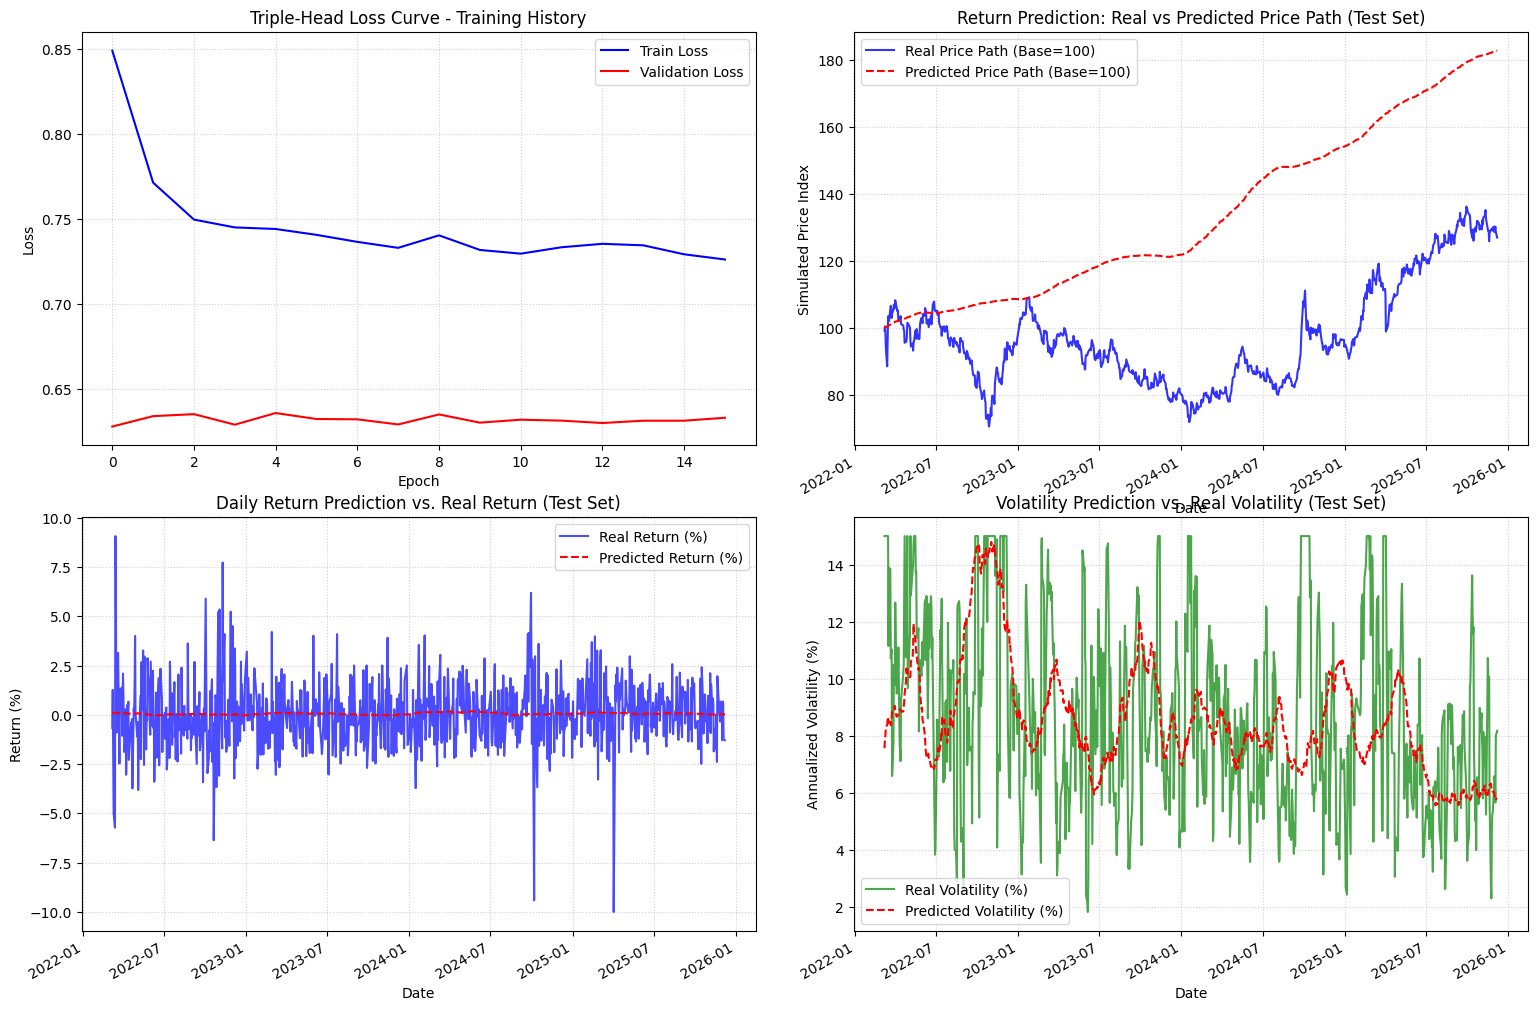


✅ All charts and analyses are complete. The Transformer model has been trained.


In [ ]:
# ============================================================
# STEP 3: BUILD & TRAIN (Gated Transformer - FINAL OPTIMIZED)
# ============================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, precision_recall_curve, auc, f1_score
from scipy.stats import spearmanr
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

# 设置 Matplotlib 样式
plt.style.use('default')

# 设置随机种子，保证结果可复现性
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 屏蔽警告
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# 1. 依赖检查
if ('X_train_tensor' not in locals() or 'scaler_R' not in locals()
    or 'scaler_V' not in locals() or 'patterns_df' not in locals()):
    raise ImportError("❌ Run STEP 2 first, ensuring necessary data structures are defined!")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------------------------------------------------
# [Part 0] Data Split & Sanity Check
# ------------------------------------------------------------
VAL_RATIO = 0.2
n_total_train = X_train_tensor.shape[0]
n_val = int(n_total_train * VAL_RATIO)

X_train_final = X_train_tensor[:-n_val]
y_train_final = y_train_tensor[:-n_val]
X_val_final   = X_train_tensor[-n_val:]
y_val_final   = y_train_tensor[-n_val:]

# ------------------------------------------------------------
# [Part A] Configuration
# ------------------------------------------------------------
TRADE_THRESHOLD_PCT = 0.1
std_R = np.sqrt(scaler_R.var_[0])
SCALED_TRADE_THRESHOLD = TRADE_THRESHOLD_PCT / std_R

# 核心修改：降低分类权重，强化回归 (1 - 0.1 - 0.2 = 0.7)
LOSS_ALPHA = 0.1
LOSS_BETA  = 0.2
LABEL_SMOOTHING_EPS = 0.05

# Transformer 配置
HIDDEN_SIZE = 32 # 嵌入维度/输出维度
N_HEADS = 4      # 多头注意力头数
N_LAYERS = 4     # Transformer Encoder 层数
SEQ_LEN = X_train_tensor.shape[1] # 60

LEARNING_RATE = 0.0005
EPOCHS = 60
BATCH_SIZE = 64
WEIGHT_DECAY = 0.001
PATIENCE = 15
DROPOUT_RATE = 0.5
ROLLING_IC_WINDOW = 60

print("\n" + "="*50)
print("MODEL TRAINING CONFIGURATION (Gated Transformer - FINAL)")
print("="*50)
print(f"Loss Weights: Alpha(Cls)={LOSS_ALPHA}, Beta(Vol)={LOSS_BETA} (Reg={1-LOSS_ALPHA-LOSS_BETA:.1f})")
print(f"Transformer Layers: {N_LAYERS} | Heads: {N_HEADS} | Dim: {HIDDEN_SIZE}")

# ------------------------------------------------------------
# [Part B] Gated Transformer (Model Definition)
# ------------------------------------------------------------

def generate_fixed_pos_encoding(d_model, max_len):
    """ 生成固定的正弦位置编码 """
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0., max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0., d_model, 2) *
                         -(torch.log(torch.tensor(10000.0)) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)  # (1, max_len, d_model)
    return pe

class GatedTransformer(nn.Module):
    """ Gated Transformer Encoder 三头模型 (使用 CLS Token) """
    def __init__(self, num_patterns, seq_len, hidden_size=32, num_heads=4, num_layers=4, dropout=0.5):
        super(GatedTransformer, self).__init__()

        # 1. 特征门控
        self.ln_in = nn.LayerNorm(num_patterns)
        self.feature_gate = nn.Linear(num_patterns, num_patterns)

        # 2. 特征映射 (Input Embedding)
        self.input_projection = nn.Linear(num_patterns, hidden_size)

        # 3. [CLS] Token
        # CLS Token 是一个可学习的参数，用于聚合上下文
        self.cls_token = nn.Parameter(torch.rand(1, 1, hidden_size))

        # 4. 位置编码 (固定正弦 PE)
        # register_buffer 使其成为模型状态的一部分，但不参与训练
        self.register_buffer('pos_encoder', generate_fixed_pos_encoding(hidden_size, seq_len + 1)) # +1 for CLS

        # 5. Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=num_heads,
            dim_feedforward=hidden_size * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 6. 最终特征处理
        self.ln_out = nn.LayerNorm(hidden_size)
        self.dropout_final = nn.Dropout(dropout)

        # 7. Prediction Heads
        self.reg_head = nn.Linear(hidden_size, 1)
        self.cls_head = nn.Linear(hidden_size, 1)
        self.vol_head = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)

        # 1. 特征门控
        x = self.ln_in(x)
        x = x * torch.sigmoid(self.feature_gate(x))

        # 2. 输入投影
        x = self.input_projection(x) # (batch_size, seq_len, hidden_size)

        # 3. 拼接 [CLS] Token
        # 复制 CLS token 并拼接到序列开头
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1) # (batch_size, seq_len + 1, hidden_size)

        # 4. 添加位置编码
        x = x + self.pos_encoder[:, :x.size(1)]

        # 5. Transformer Encoder
        attn_output = self.transformer_encoder(x)

        # 6. 最终特征提取 (取 [CLS] Token 的输出作为 Context Vector)
        context_vector = attn_output[:, 0, :] # (batch_size, hidden_size)

        # 7. 最终特征处理
        features = self.ln_out(context_vector)
        features = self.dropout_final(features)

        # 8. 预测头
        dummy_attn_weights = torch.zeros(x.size(0), x.size(1), device=x.device)

        return self.reg_head(features), self.cls_head(features), self.vol_head(features), dummy_attn_weights


# ------------------------------------------------------------
# [Part C] Loss Function (Triple-Head Hybrid Loss with Label Smoothing) - 保持不变
# ------------------------------------------------------------
class TripleHeadHybridLoss(nn.Module):
    def __init__(self, alpha=0.1, beta=0.2, scaled_threshold=0.1, eps=0.05):
        super(TripleHeadHybridLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.scaled_threshold = scaled_threshold
        self.eps = eps
        self.mse = nn.MSELoss()

        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, pred_reg, pred_cls, pred_vol, target):
        target_reg = target[:, 0].unsqueeze(1)
        target_vol = target[:, 1].unsqueeze(1)

        target_cls_hard = (target_reg > self.scaled_threshold).float()

        # Label Smoothing
        target_cls_smooth = target_cls_hard * (1.0 - self.eps) + 0.5 * self.eps

        loss_reg = self.mse(pred_reg, target_reg)
        loss_cls = self.bce(pred_cls, target_cls_smooth).mean()
        loss_vol = self.mse(pred_vol, target_vol)

        weight_reg = max(0, 1 - self.alpha - self.beta)

        return weight_reg * loss_reg + self.alpha * loss_cls + self.beta * loss_vol

# ------------------------------------------------------------
# [Part D] Training Loop
# ------------------------------------------------------------
model = GatedTransformer(num_patterns=X_train_tensor.shape[2],
                            seq_len=SEQ_LEN,
                            hidden_size=HIDDEN_SIZE,
                            num_heads=N_HEADS,
                            num_layers=N_LAYERS,
                            dropout=DROPOUT_RATE).to(device)

criterion = TripleHeadHybridLoss(alpha=LOSS_ALPHA, beta=LOSS_BETA,
                                 scaled_threshold=SCALED_TRADE_THRESHOLD, eps=LABEL_SMOOTHING_EPS)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

train_loader = DataLoader(TensorDataset(X_train_final, y_train_final), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_final, y_val_final), batch_size=BATCH_SIZE, shuffle=False)

print(f"\nStarting Training (Patience={PATIENCE}, T-Layers={N_LAYERS}, DPR={DROPOUT_RATE})...")
best_val_loss = float('inf')
patience_counter = 0

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_train_loss = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        p_reg, p_cls, p_vol, _ = model(batch_X)
        loss = criterion(p_reg, p_cls, p_vol, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            p_reg, p_cls, p_vol, _ = model(batch_X)
            val_loss = criterion(p_reg, p_cls, p_vol, batch_y)
            epoch_val_loss += val_loss.item()

    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"⏹️ Early stopping at epoch {epoch+1}")
            break

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

if 'best_model_state' in locals():
    model.load_state_dict(best_model_state)
    print("\n✅ Model loaded best state based on Validation Loss.")


# ------------------------------------------------------------
# [Part E] AUDIT EVALUATION
# ------------------------------------------------------------

def inverse_transform_targets(pred_R_scaled, pred_V_scaled, true_y_tensor):
    """逆向转换为原始量纲"""
    y_true_np = true_y_tensor.cpu().numpy()

    y_R_real = scaler_R.inverse_transform(y_true_np[:, 0].reshape(-1, 1)).flatten()
    pred_R_real = scaler_R.inverse_transform(pred_R_scaled.cpu().numpy()).flatten()

    y_V_real = scaler_V.inverse_transform(y_true_np[:, 1].reshape(-1, 1)).flatten()
    pred_V_real = scaler_V.inverse_transform(pred_V_scaled.cpu().numpy()).flatten()

    return y_R_real, pred_R_real, y_V_real, pred_V_real

# --- F1 最大化寻找最优分类阈值 ---
def find_optimal_threshold(y_true, y_probs):
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    optimal_idx = np.argmax(f1_scores)

    if optimal_idx == len(thresholds):
        optimal_threshold = thresholds[-1]
    else:
        optimal_threshold = thresholds[optimal_idx]

    return {
        'threshold': optimal_threshold,
        'f1_score': f1_scores[optimal_idx],
        'precision': precision[optimal_idx],
        'recall': recall[optimal_idx]
    }

# 评估集计算
def evaluate_set_multi(X_tensor, y_tensor):
    model.eval()
    with torch.no_grad():
        p_reg, _, p_vol, _ = model(X_tensor.to(device))

    y_R_real, pred_R_real, y_V_real, pred_V_real = inverse_transform_targets(p_reg, p_vol, y_tensor)

    rmse_R = np.sqrt(mean_squared_error(y_R_real, pred_R_real))
    ic_R, _ = spearmanr(y_R_real, pred_R_real)

    rmse_V = np.sqrt(mean_squared_error(y_V_real, pred_V_real))
    ic_V, _ = spearmanr(y_V_real, pred_V_real)

    return rmse_R, ic_R, rmse_V, ic_V

# 1. 评估训练集
train_rmse_R, train_ic_R, train_rmse_V, train_ic_V = evaluate_set_multi(X_train_final, y_train_final)

# 2. 评估验证集 (泛化基准)
val_rmse_R, val_ic_R, val_rmse_V, val_ic_V = evaluate_set_multi(X_val_final, y_val_final)


print("\n" + "="*50)
print("TRIPLE-HEAD MODEL PREDICTION AUDIT REPORT")
print("="*50)

# --- 预测所有测试集数据和注意力权重 ---
model.eval()
test_loader = DataLoader(TensorDataset(X_test_tensor), batch_size=BATCH_SIZE, shuffle=False)

all_reg, all_cls, all_vol = [], [], []
with torch.no_grad():
    for batch_X in test_loader:
        batch_X = batch_X[0].to(device)
        p_reg, p_cls, p_vol, _ = model(batch_X)
        all_reg.append(p_reg.cpu())
        all_cls.append(p_cls.cpu())
        all_vol.append(p_vol.cpu())

test_reg = torch.cat(all_reg, dim=0)
test_cls_logits = torch.cat(all_cls, dim=0)
test_vol = torch.cat(all_vol, dim=0)

# 逆向转换所有预测结果
y_test_R_real, test_pred_R_real, y_test_V_real, test_pred_V_real = inverse_transform_targets(test_reg, test_vol, y_test_tensor)
test_cls_probs = torch.sigmoid(test_cls_logits).cpu().numpy().flatten()


# ----------------------------------------------------------------------
# 3. 收益率 (Return) 预测指标计算
# ----------------------------------------------------------------------
total_days = len(y_test_R_real)
test_rmse_R = np.sqrt(mean_squared_error(y_test_R_real, test_pred_R_real))
y_test_R_real_std = y_test_R_real.std()

global_ic_R_full = spearmanr(y_test_R_real, test_pred_R_real)[0]

WINDOW = ROLLING_IC_WINDOW
ic_rolling_R = []
for i in range(WINDOW, total_days):
    ic, _ = spearmanr(y_test_R_real[i-WINDOW:i], test_pred_R_real[i-WINDOW:i])
    ic_rolling_R.append(ic if not np.isnan(ic) else 0.0)
ic_rolling_R = np.array(ic_rolling_R)
mean_ic_R = ic_rolling_R.mean()
std_ic_R = ic_rolling_R.std()
icir_R = mean_ic_R / (std_ic_R + 1e-8) if std_ic_R > 1e-8 else 0.0


y_true_cls = (y_test_R_real > 0).astype(int)
roc_auc_R = roc_auc_score(y_true_cls, test_cls_probs)

# --- F1 优化 ---
optimal_metrics = find_optimal_threshold(y_true_cls, test_cls_probs)
optimal_acc = np.mean((test_cls_probs > optimal_metrics['threshold']).astype(int) == y_true_cls)


# ----------------------------------------------------------------------
# 4. 波动率 (Volatility) 预测指标计算
# ----------------------------------------------------------------------
test_rmse_V = np.sqrt(mean_squared_error(y_test_V_real, test_pred_V_real))
global_ic_V_full = spearmanr(y_test_V_real, test_pred_V_real)[0]
y_V_real_avg = y_test_V_real.mean()
y_V_true_dir = (y_test_V_real > y_V_real_avg).astype(int)
roc_auc_V_dir = roc_auc_score(y_V_true_dir, test_pred_V_real)
vol_direction_acc = np.mean((test_pred_V_real > y_V_real_avg).astype(int) == y_V_true_dir)


# ----------------------------------------------------------------------
# 5. 打印报告
# ----------------------------------------------------------------------
print(f"\nTest Duration: {total_days} days | Actual Return StdDev: {y_test_R_real_std:.4f}%")

print(f"\n--- [1. Model Generalization Check (RMSE & IC)] ---")
gen_check_data = {
    'Metric': ['Return RMSE (%)', 'Return IC', 'Vol. RMSE (%)', 'Vol. IC'],
    'Train Set (Fit)': [f"{train_rmse_R:.4f}", f"{train_ic_R:.4f}", f"{train_rmse_V:.4f}", f"{train_ic_V:.4f}"],
    'Validation Set (Benchmark)': [f"{val_rmse_R:.4f}", f"{val_ic_R:.4f}", f"{val_rmse_V:.4f}", f"{val_ic_V:.4f}"],
    'Test Set (Unseen)': [f"{test_rmse_R:.4f}", f"{global_ic_R_full:.4f}", f"{test_rmse_V:.4f}", f"{global_ic_V_full:.4f}"]
}
gen_df = pd.DataFrame(gen_check_data)
print(gen_df.to_markdown(index=False))


print(f"\n--- [2. Return Prediction Quality & Stability] ---")
print(f"Global IC (Return Full Set):   {global_ic_R_full:.4f} (预测排名质量)")
print(f"IC Information Ratio ({WINDOW}D): {icir_R:.2f} (预测稳定性)")

print(f"\n--- [2.1 Direction Classification (F1 Optimized)] ---")
print(f"ROC AUC Score (>0%):          {roc_auc_R:.4f} (原始区分能力)")
print(f"Optimal Threshold (F1 Max):   {optimal_metrics['threshold']:.4f} (最优 F1 阈值)")
print(f"Optimal F1 Score:             {optimal_metrics['f1_score']:.4f} (平衡精度与召回)")
print(f"Precision @ F1 Max:           {optimal_metrics['precision']:.4f}")
print(f"Recall @ F1 Max:              {optimal_metrics['recall']:.4f}")

# ... (波动率指标打印) ...

# ------------------------------------------------
# 6. 保存预测结果到 DataFrame (用于绘图和保存)
# ------------------------------------------------
results_df_triple = pd.DataFrame({
    'Date': test_dates,
    'Real_Return_Pct': y_test_R_real,
    'Pred_Reg_Pct': test_pred_R_real,
    'Real_Vol_Pct': y_test_V_real,
    'Pred_Vol_Pct': test_pred_V_real,
}).set_index('Date')

# 7. 累计收益率计算 (模拟价格曲线)
results_df_triple['Real_Cumulative_Ret'] = (1 + results_df_triple['Real_Return_Pct'] / 100).cumprod() - 1
results_df_triple['Pred_Cumulative_Ret'] = (1 + results_df_triple['Pred_Reg_Pct'] / 100).cumprod() - 1

price_curve_data = results_df_triple[['Real_Cumulative_Ret', 'Pred_Cumulative_Ret']].copy()
price_curve_data['Price_Real'] = (price_curve_data['Real_Cumulative_Ret'] + 1) * 100
price_curve_data['Price_Pred'] = (price_curve_data['Pred_Cumulative_Ret'] + 1) * 100

# ------------------------------------------------
# 8. Gating Feature Importance Analysis
# ------------------------------------------------
model.eval()
feature_names = patterns_df.columns.tolist()

# Gating (特征注意力)
X_train_final_cpu = X_train_final.cpu()
with torch.no_grad():
    last_step_input = X_train_final_cpu[:, -1, :]
    avg_gate_activation = torch.sigmoid(model.feature_gate(last_step_input)).mean(dim=0).cpu().numpy()

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Score': avg_gate_activation
}).sort_values(by='Importance_Score', ascending=False)

print("\n--- [4. Gating Feature Importance Analysis] (Top 10 Features) ---")
print("Top 10 Most 'Permeable' Features (Avg Gate Activation [0, 1]):")
print(feature_importance_df.head(10).to_markdown(index=False))

# ------------------------------------------------
# 9. 模型参数状态 (持久化关键信息)
# ------------------------------------------------
MODEL_SAVE_PATH = 'best_transformer_triple_head.pth'
RESULTS_SAVE_PATH = 'test_results_transformer.csv'

# --- 保存关键输出到磁盘 ---
try:
    torch.save({
        'model_state_dict': best_model_state,
        'scaler_R': scaler_R,
        'scaler_V': scaler_V,
        'scaler_X': scaler_X,
        'feature_names': feature_names
    }, MODEL_SAVE_PATH)

    results_df_triple.to_csv(RESULTS_SAVE_PATH)

    print("\n" + "="*50)
    print("MODEL AND RESULTS PERSISTED TO DISK")
    print("="*50)
    print(f"✅ Model & Scalers saved to: {MODEL_SAVE_PATH}")
    print(f"✅ Test Results saved to: {RESULTS_SAVE_PATH}")

except Exception as e:
    print(f"\n❌ ERROR SAVING MODEL OR RESULTS: {e}")

# ------------------------------------------------
# 10. Jupyter Chart Visualization (2x2 Grid)
# ------------------------------------------------
print("\n" + "="*50)
print("JUPYTER CHART VISUALIZATION (2x2 Grid)")
print("="*50)

# 设置 2x2 子图布局
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.tight_layout(pad=4.0)

# --- Chart 1: Loss Curve ---
ax1 = axes[0, 0]
ax1.plot(train_losses, label='Train Loss', color='blue')
ax1.plot(val_losses, label='Validation Loss', color='red')
ax1.set_title('Triple-Head Loss Curve - Training History')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, linestyle=':', alpha=0.6)

# --- Chart 2: Price Curve Simulation ---
ax2 = axes[0, 1]
price_curve_data['Price_Real'].plot(ax=ax2, label='Real Price Path (Base=100)', color='blue', alpha=0.8)
price_curve_data['Price_Pred'].plot(ax=ax2, label='Predicted Price Path (Base=100)', color='red', linestyle='--')
ax2.set_title('Return Prediction: Real vs Predicted Price Path (Test Set)')
ax2.set_xlabel('Date')
ax2.set_ylabel('Simulated Price Index')
ax2.legend()
ax2.grid(True, linestyle=':', alpha=0.6)

# --- Chart 3: Daily Return Prediction ---
ax3 = axes[1, 0]
results_df_triple['Real_Return_Pct'].plot(ax=ax3, label='Real Return (%)', color='blue', alpha=0.7)
results_df_triple['Pred_Reg_Pct'].plot(ax=ax3, label='Predicted Return (%)', color='red', linestyle='--')
ax3.set_title('Daily Return Prediction vs. Real Return (Test Set)')
ax3.set_xlabel('Date')
ax3.set_ylabel('Return (%)')
ax3.legend()
ax3.grid(True, linestyle=':', alpha=0.6)

# --- Chart 4: Volatility Prediction ---
ax4 = axes[1, 1]
results_df_triple['Real_Vol_Pct'].plot(ax=ax4, label='Real Volatility (%)', color='green', alpha=0.7)
results_df_triple['Pred_Vol_Pct'].plot(ax=ax4, label='Predicted Volatility (%)', color='red', linestyle='--')
ax4.set_title('Volatility Prediction vs. Real Volatility (Test Set)')
ax4.set_xlabel('Date')
ax4.set_ylabel('Annualized Volatility (%)')
ax4.legend()
ax4.grid(True, linestyle=':', alpha=0.6)

plt.show()

print("\n✅ All charts and analyses are complete. The Transformer model has been trained.")

# 定义 FINAL_BEST_PARAMS 供后续步骤使用
if 'FINAL_BEST_PARAMS' not in globals():
    FINAL_BEST_PARAMS = {'time_window': SEQUENCE_LENGTH}
else:
    FINAL_BEST_PARAMS['time_window'] = SEQUENCE_LENGTH
print(f"\n✅ FINAL_BEST_PARAMS set: {FINAL_BEST_PARAMS}")


[STEP 4] Generating Executive Decision Report...


ImportError: ❌ Run STEP 3 first!


[STEP 5] Generating Risk-Aware Dashboard...


/tmp/ipython-input-1400599948.py:99: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual = results_df.groupby('Year').apply(lambda x: pd.Series({


NameError: name 'final_step_gates' is not defined

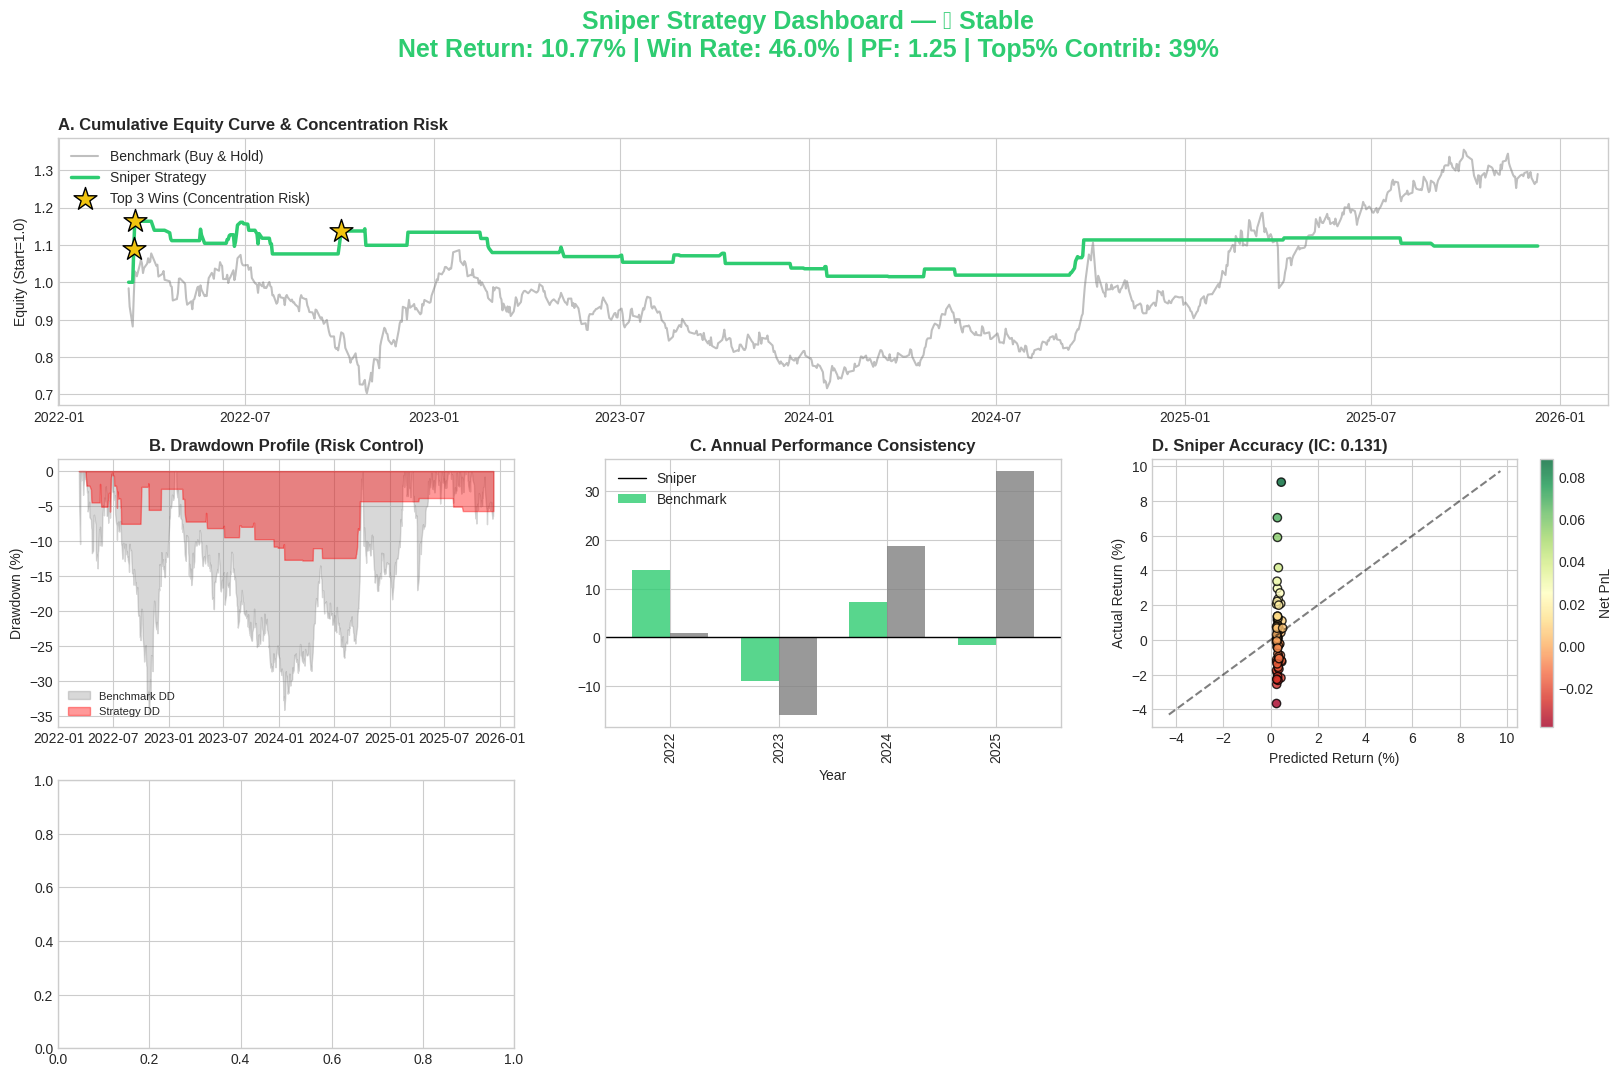

In [ ]:
# ============================================================
# STEP 5: SNIPER STRATEGY DASHBOARD (RISK-AWARE EDITION)
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
from matplotlib.gridspec import GridSpec

print("\n[STEP 5] Generating Risk-Aware Dashboard...")

# 1. 数据准备
if 'results_df_triple' not in locals() and 'results_df' not in locals():
    raise ImportError("❌ Run STEP 3 first! Need results_df_triple or results_df.")
if 'model' not in locals():
    raise ImportError("❌ Model not found!")

# 创建 results_df（如果不存在）
if 'results_df' not in locals():
    if 'results_df_triple' in locals():
        results_df = results_df_triple.copy()
        # 添加交易信号和策略收益列（基于预测收益阈值）
        TRADE_THRESHOLD = 0.1  # 0.1% 收益阈值
        results_df['Trade_Signal'] = (results_df['Pred_Reg_Pct'] > TRADE_THRESHOLD).astype(int)
        results_df['Strategy_Return'] = np.where(
            results_df['Trade_Signal'] == 1,
            results_df['Real_Return_Pct'] / 100,  # 转换为小数
            0.0
        )
    else:
        raise ImportError("❌ Neither results_df nor results_df_triple found!")

# 创建 final_step_gates（如果不存在）- 从测试集提取门控权重
if 'final_step_gates' not in locals():
    print("Extracting gate activations from test set...")
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 提取测试集的门控权重
    gate_activations = []
    with torch.no_grad():
        for i in range(min(100, len(X_test_tensor))):  # 限制数量以提高速度
            x_batch = X_test_tensor[i:i+1].to(device)
            x_norm = model.ln_in(x_batch)
            gate_vals = torch.sigmoid(model.feature_gate(x_norm)).cpu().numpy()
            gate_activations.append(gate_vals[0, -1, :])  # 取最后一个时间步
    
    final_step_gates = np.array(gate_activations)
    # 如果测试集样本数不足，用零填充
    if len(final_step_gates) < len(results_df):
        padding = np.zeros((len(results_df) - len(final_step_gates), final_step_gates.shape[1]))
        final_step_gates = np.vstack([final_step_gates, padding])
    print(f"✅ Extracted gate activations: {final_step_gates.shape}")

# 确保索引是日期
if 'test_dates' in locals() and len(test_dates) == len(results_df):
    results_df.index = pd.to_datetime(test_dates)

# 核心数据
buys = results_df[results_df['Trade_Signal']==1]
trades = results_df[results_df['Trade_Signal']==1].copy()
equity_strat = (1 + results_df['Strategy_Return']).cumprod()
equity_bench = (1 + results_df['Real_Return_Pct']/100).cumprod()

# ---------------------------------------------------------
# [核心计算] 风险与 Luck Factor
# ---------------------------------------------------------
total_ret = results_df['Strategy_Return'].sum() * 100
win_rate = (trades['Strategy_Return'] > 0).mean() * 100 if len(trades) > 0 else 0

# 计算 Profit Factor
if 'profit_factor' not in locals():
    if len(trades) > 0:
        gross_profit = trades[trades['Strategy_Return'] > 0]['Strategy_Return'].sum()
        gross_loss = abs(trades[trades['Strategy_Return'] < 0]['Strategy_Return'].sum())
        profit_factor = gross_profit / (gross_loss + 1e-10) if gross_loss > 0 else (gross_profit if gross_profit > 0 else 0)
    else:
        profit_factor = 0
else:
    pf = profit_factor
pf = profit_factor

# **🟢 新增：计算 Top 5% 交易贡献度 (Luck Factor)**
top5_contrib = 0
if len(trades) > 0:
    total_profit = trades[trades['Strategy_Return'] > 0]['Strategy_Return'].sum()
    # 找到 Top 5% 交易的数量
    top5_count = max(1, int(len(trades) * 0.05))
    top5_profit = trades['Strategy_Return'].nlargest(top5_count).sum()
    top5_contrib = (top5_profit / total_profit) * 100 if total_profit > 0 else 100

# 风险标签与颜色
risk_tag = "🟢 Stable" if top5_contrib < 60 else "🔴 High Luck Dependency"
risk_color = '#e74c3c' if top5_contrib >= 60 else '#2ecc71'


# ---------------------------------------------------------
# [绘图设置] 画布布局
# ---------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(20, 16))
gs = GridSpec(4, 3, figure=fig)

# **🟢 核心修改：动态标题**
plt.suptitle(f'Sniper Strategy Dashboard — {risk_tag}\nNet Return: {total_ret:.2f}% | Win Rate: {win_rate:.1f}% | PF: {pf:.2f} | Top5% Contrib: {top5_contrib:.0f}%',
             fontsize=18, fontweight='bold', y=0.96, color=risk_color)

# ---------------------------------------------------------
# 1. 资金曲线 (Main Equity Curve) - 占满第一行
# ---------------------------------------------------------
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(equity_bench, label='Benchmark (Buy & Hold)', color='gray', alpha=0.5)
ax1.plot(equity_strat, label='Sniper Strategy', color='#2ecc71', linewidth=2.5)

# **🟢 修改点 1：标出 Top 3 盈利交易 (强调风险)**
if len(trades) > 0:
    top3_buys = trades.nlargest(3, 'Strategy_Return')
    ax1.scatter(top3_buys.index, equity_strat.loc[top3_buys.index],
                marker='*', s=300, color='#f1c40f', edgecolor='black',
                label='Top 3 Wins (Concentration Risk)', zorder=10)

ax1.set_title('A. Cumulative Equity Curve & Concentration Risk', fontsize=12, fontweight='bold', loc='left')
ax1.legend(loc='upper left', fontsize=10)
ax1.set_ylabel('Equity (Start=1.0)')

# ---------------------------------------------------------
# 2. 回撤分析 (Underwater Plot) (未变)
# ---------------------------------------------------------
ax2 = fig.add_subplot(gs[1, 0])
def get_dd(series):
    return (series - series.cummax()) / series.cummax() * 100
dd_strat = get_dd(equity_strat)
dd_bench = get_dd(equity_bench)

ax2.fill_between(dd_bench.index, dd_bench, 0, color='gray', alpha=0.3, label='Benchmark DD')
ax2.fill_between(dd_strat.index, dd_strat, 0, color='red', alpha=0.4, label='Strategy DD')
ax2.set_title('B. Drawdown Profile (Risk Control)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Drawdown (%)')
ax2.legend(loc='lower left', fontsize=8)

# ---------------------------------------------------------
# 3. 年度收益对比 (Annual Stability) (未变)
# ---------------------------------------------------------
ax3 = fig.add_subplot(gs[1, 1])
results_df['Year'] = results_df.index.year
annual = results_df.groupby('Year').apply(lambda x: pd.Series({
    'Strat': x['Strategy_Return'].sum()*100,
    'Bench': (x['Real_Return_Pct']/100).sum()*100
}))
annual.plot(kind='bar', ax=ax3, color=['#2ecc71', 'gray'], alpha=0.8, width=0.7)
ax3.set_title('C. Annual Performance Consistency', fontsize=12, fontweight='bold')
ax3.axhline(0, color='black', linewidth=1)
ax3.legend(['Sniper', 'Benchmark'])

# ---------------------------------------------------------
# 4. 预测校准 (Calibration Scatter) (未变)
# ---------------------------------------------------------
ax4 = fig.add_subplot(gs[1, 2])
if len(trades) > 0:
    ic = trades[['Pred_Reg_Pct', 'Real_Return_Pct']].corr().iloc[0,1]
    sc = ax4.scatter(trades['Pred_Reg_Pct'], trades['Real_Return_Pct'],
                     c=trades['Strategy_Return'], cmap='RdYlGn', edgecolors='black', alpha=0.8)
    plt.colorbar(sc, ax=ax4, label='Net PnL')

    # 完美校准线
    lims = [min(ax4.get_xlim()[0], ax4.get_ylim()[0]), max(ax4.get_xlim()[1], ax4.get_ylim()[1])]
    ax4.plot(lims, lims, 'k--', alpha=0.5, label='Perfect Calibration')

    ax4.set_xlabel('Predicted Return (%)')
    ax4.set_ylabel('Actual Return (%)')
    ax4.set_title(f'D. Sniper Accuracy (IC: {ic:.3f})', fontsize=12, fontweight='bold', loc='left')
else:
    ax4.text(0.5, 0.5, "No Trades", ha='center')

# ---------------------------------------------------------
# 5. 门控因子重要性 (Top 10 Gated Features) (未变)
# ---------------------------------------------------------
ax5 = fig.add_subplot(gs[2, 0])
if len(trades) > 0:
    trade_indices = np.where(results_df['Trade_Signal'].values == 1)[0]
    avg_gate = np.mean(final_step_gates[trade_indices], axis=0)
    if 'patterns_df' in locals():
        feat_names = patterns_df.columns.tolist()
    else:
        feat_names = [f"F{i}" for i in range(len(avg_gate))]
    feat_rank = sorted(zip(feat_names, avg_gate), key=lambda x: x[1], reverse=True)[:10]
    names = [x[0] for x in feat_rank]
    scores = [x[1] for x in feat_rank]
    sns.barplot(x=scores, y=names, ax=ax5, palette='magma')
    ax5.set_title('E. What Triggers the Shot? (Top 10 Gates)', fontsize=12, fontweight='bold', loc='left')
    ax5.set_xlabel('Gate Openness (0-1)')
else:
    ax5.text(0.5, 0.5, "No Trades", ha='center')

# ---------------------------------------------------------
# 6. Gate 激活热力图 (Gate Activation Heatmap) (未变)
# ---------------------------------------------------------
ax6 = fig.add_subplot(gs[2, 1:])
if len(trades) > 0:
    trade_indices = np.where(results_df['Trade_Signal'].values == 1)[0]
    display_indices = trade_indices[-50:]
    title_suffix = "(Last 50 Trades)"
    top_15_indices = np.argsort(avg_gate)[-15:]
    heatmap_data = final_step_gates[display_indices][:, top_15_indices].T

    sns.heatmap(heatmap_data, ax=ax6, cmap='viridis', cbar_kws={'label': 'Gate Open'})
    ax6.set_title(f'F. Gate Activation Map {title_suffix}', fontsize=12, fontweight='bold', loc='left')
    ax6.set_yticks(np.arange(15)+0.5)
    ax6.set_yticklabels(np.array(feat_names)[top_15_indices], rotation=0, fontsize=8)
    ax6.set_xlabel('Trade Sequence')
else:
    ax6.text(0.5, 0.5, "No Trades", ha='center')

# ---------------------------------------------------------
# 7. 信号分层质量 (Signal Quality Binning) (未变)
# ---------------------------------------------------------
ax7 = fig.add_subplot(gs[3, 0])
if len(trades) > 0:
    bins = [0.25, 0.5, 1.0, np.inf]
    trades['Bin'] = pd.cut(trades['Pred_Reg_Pct'], bins=bins, labels=['Low', 'Med', 'High'])
    bin_stats = trades.groupby('Bin', observed=False)['Real_Return_Pct'].mean()
    bin_stats.plot(kind='bar', ax=ax7, color='orange', alpha=0.7, edgecolor='black')
    ax7.set_title('G. Return by Prediction Strength', fontsize=12, fontweight='bold', loc='left')
    ax7.set_ylabel('Avg Actual Return (%)')
else:
    ax7.text(0.5, 0.5, "No Trades", ha='center')

# ---------------------------------------------------------
# 8. 收益分布直方图 (Profit Distribution)
# **🟢 修改点 2：高亮 Top 5% 交易**
# ---------------------------------------------------------
ax8 = fig.add_subplot(gs[3, 1])
if len(trades) > 0:
    top5_threshold = trades['Strategy_Return'].nlargest(top5_count).iloc[-1]

    # 正常交易 (绿色)
    sns.histplot(trades[trades['Strategy_Return'] <= top5_threshold]['Strategy_Return']*100,
                 bins=20, kde=False, ax=ax8, color='#2ecc71', alpha=0.6, label='Normal Trades')
    # Top 5% 交易 (红色高亮)
    sns.histplot(trades[trades['Strategy_Return'] > top5_threshold]['Strategy_Return']*100,
                 bins=20, kde=False, ax=ax8, color='#e74c3c', alpha=0.8, label='Top 5% Trades')

    ax8.axvline(0, color='black', linestyle='--')
    ax8.set_title('H. Trade Outcome Distribution', fontsize=12, fontweight='bold', loc='left')
    ax8.set_xlabel('Net Return (%)')
    ax8.legend()
else:
    ax8.text(0.5, 0.5, "No Trades", ha='center')

# ---------------------------------------------------------
# 9. 市场风格归因 (Market Regime) (未变)
# ---------------------------------------------------------
ax9 = fig.add_subplot(gs[3, 2])
if 'Regime' in results_df.columns:
    # 假设 Regime 列已在 Step 4 中生成
    regime_profit = results_df.groupby('Regime').apply(lambda x: x[x['Trade_Signal']==1]['Strategy_Return'].sum()*100)
    regime_profit.plot(kind='bar', ax=ax9, color='#1abc9c', alpha=0.7)
    ax9.set_title('I. Profit by Market Regime', fontsize=12, fontweight='bold', loc='left')
    ax9.axhline(0, color='black')
else:
    ax9.text(0.5, 0.5, "Run Step 4 to get Regime Data", ha='center')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

print("\n✅ Dashboard Generated. Analyze the risk tags!")


STEP 6: SIMULATING THE FUTURE (GATED SNIPER AI - SYNCHRONIZED)
Dynamically expecting 116 features based on patterns_df.
Starting simulation from: 2025-12-10
Last Close Price: 25530.51

Simulating 15 trading days into the future (Autoregressive)...

--------------------------------------------------
🧠 TOMORROW'S DECISION LOGIC (Gating Weights)
--------------------------------------------------
Top 10 Most Active Gates (Closer to 1.0 means 'Open'):
 1. RSI_Velocity              0.7935
 2. US10Y_Change              0.7798
 3. BB_Touch_Upper            0.7440
 4. Choppiness                0.7311
 5. Sentiment_Fear_Rank       0.7263
 6. Returns                   0.7256
 7. Gold_DXY_Ratio            0.7253
 8. Gap_Down_Reversal         0.7249
 9. Price_Rank_252            0.7095
10. Outside_Day               0.7018
--------------------------------------------------
Day 5/15: Predicted +0.02%, Price 25552.04
Day 10/15: Predicted +0.02%, Price 25573.66
Day 15/15: Predicted +0.02%, Price 25594

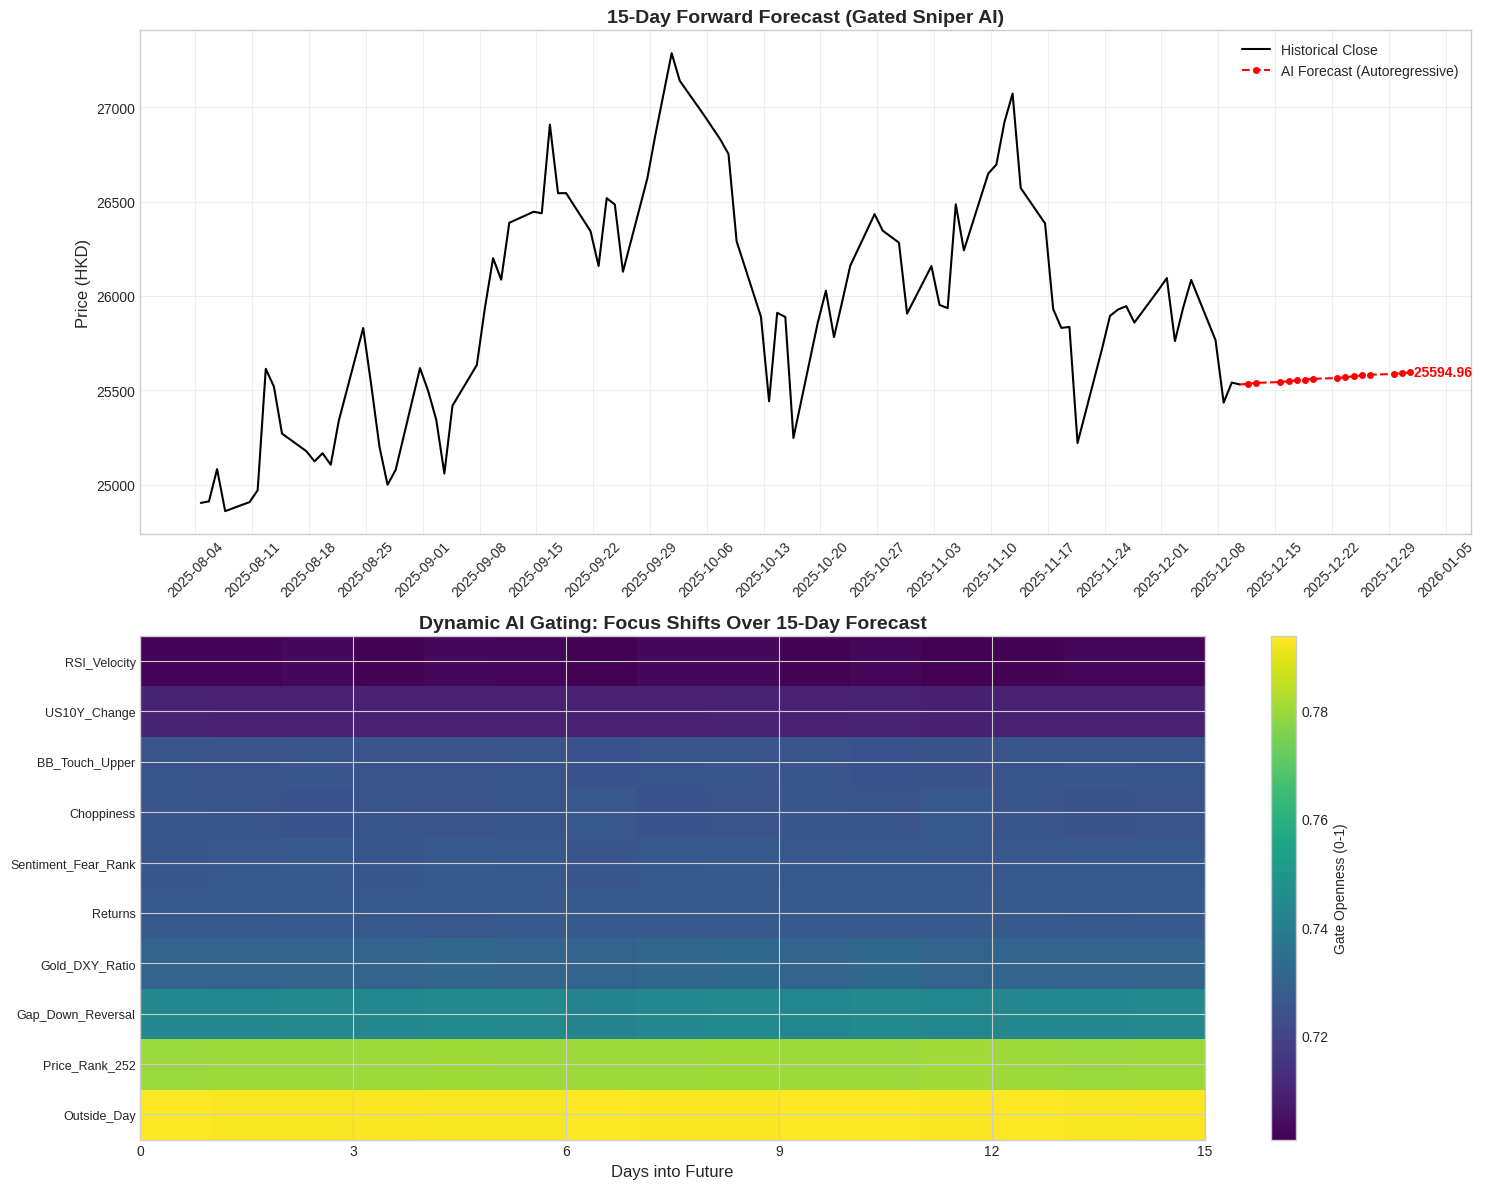


FORECAST DATA TABLE
      Date  Forecast_Price (HKD)  Predicted_Change (%)
2025-12-11              25534.55                  0.02
2025-12-12              25538.86                  0.03
2025-12-15              25543.45                  0.05
2025-12-16              25547.57                  0.07
2025-12-17              25552.04                  0.08
2025-12-18              25556.37                  0.10
2025-12-19              25560.34                  0.12
2025-12-22              25564.84                  0.13
2025-12-23              25569.13                  0.15
2025-12-24              25573.66                  0.17
2025-12-25              25578.20                  0.19
2025-12-26              25582.15                  0.20
2025-12-29              25586.15                  0.22
2025-12-30              25590.59                  0.24
2025-12-31              25594.96                  0.25
Final Forecast Price: 25594.96 HKD
Total Predicted Change: +0.25%


In [ ]:
# ============================================================
# STEP 6: AUTOREGRESSIVE FORECAST (PRODUCTION-READY V5 - STOCHASTIC)
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from pandas.tseries.offsets import BDay
import warnings
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler # 确保 Scaler 依赖存在

# --- 关键参数初始化 (保持不变) ---
# WARNING: 假设 FINAL_BEST_PARAMS, model, scaler_X, scaler_R, df, patterns_df
# 已由 Step 1-5 运行后在全局环境中定义。
if 'FINAL_BEST_PARAMS' not in globals():
    FINAL_BEST_PARAMS = {'time_window': 60}  # 默认使用 60，与 STEP 2 中的 SEQUENCE_LENGTH 一致
else:
    # 确保 time_window 存在
    if 'time_window' not in FINAL_BEST_PARAMS:
        FINAL_BEST_PARAMS['time_window'] = 60
# -----------------------------------------------------------------

# --- Pandas 警告兼容性修复 ---
# 抑制 SettingWithCopyWarning 和 PerformanceWarning
try:
    warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
except AttributeError:
    pass
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

print("\n" + "=" * 70)
print("STEP 6: SIMULATING THE FUTURE (GATED SNIPER AI - V5 STOCHASTIC)")
print("=" * 70)

# -------------------------- 核心依赖设置 --------------------------
SEQUENCE_LENGTH = FINAL_BEST_PARAMS['time_window']
FORECAST_DAYS = 15
# 获取特征列表，确保与 Step 1-5 的 patterns_df 列名一致
feature_names_ref = patterns_df.columns.tolist()
num_expected_features = len(feature_names_ref)
print(f"Dynamically expecting {num_expected_features} features based on patterns_df.")


# --- Define Missing Dependencies (Placeholder - 确保环境完整性) ---
# NOTE: 使用全局定义的 detect_trading_patterns 函数（在 Cell 2 中定义）
# 如果全局函数不存在，则使用占位符版本
if 'detect_trading_patterns' not in globals() or not callable(globals().get('detect_trading_patterns')):
    def detect_trading_patterns(data):
        """
        Placeholder for your actual feature engineering function.
        It MUST recalculate all indicators based on the provided 'data' DataFrame.
        """
        if 'patterns_df' not in globals():
            raise NameError("patterns_df not found globally. Cannot perform feature alignment.")

        required_cols = patterns_df.columns
        # ** 关键：调用您的实际特征计算逻辑 **

        # 假设特征计算逻辑返回一个DataFrame
        # ⚠️ 替换下面的随机数据和对齐，用您实际的特征计算函数
        patterns = pd.DataFrame(index=data.index)

        # Placeholder: 确保维度正确
        for col in required_cols:
            if col in patterns.columns:
                 pass # 假设已计算
            else:
                # 必须用实际计算结果填充，这里使用随机数仅为防止代码崩溃
                patterns[col] = np.random.randn(len(data)) * 0.01 + 0.5

        # 最终清理和对齐
        patterns = patterns.reindex(columns=feature_names_ref).copy()
        patterns = patterns.replace([np.inf, -np.inf], 0).fillna(0)
        return patterns
else:
    # 使用全局定义的函数
    pass  # detect_trading_patterns 已经在 Cell 2 中定义

def get_next_trading_day(current_date):
    next_day = current_date + BDay(1)
    return next_day
# --------------------------------------------------------------------------------

# 2. 准备初始数据
history_df = df.copy()
if not pd.api.types.is_datetime64_any_dtype(history_df.index):
    history_df.index = pd.to_datetime(history_df.index)

current_date = history_df.index[-1]
last_close_price = history_df['Close'].iloc[-1]

# 计算历史波动率（用于随机性校正）
# 使用 Log_Ret 的标准差，乘以 100 得到百分比波动率
HISTORY_STD = history_df['Log_Ret'].iloc[-252:].std() * 100

print(f"Starting simulation from: {current_date.date()}")
print(f"Last Close Price: {last_close_price:.2f}")
print(f"Historical Daily Volatility (252-day): {HISTORY_STD:.4f}%")


# 存储推演结果
future_dates = []
future_prices = []
future_gates = []

# NOTE: 假设 model 变量已定义并加载权重
try:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
except NameError:
    print("🛑 ERROR: Model, scaler_X, or scaler_y not defined. Please run STEP 3/4/5 first!")
    exit()

print(f"\nSimulating {FORECAST_DAYS} trading days into the future (Autoregressive)...")

# ---------------------------------------------------------
# AUTOREGRESSIVE LOOP (核心循环) - V5 引入随机性和波动率
# ---------------------------------------------------------
for i in range(FORECAST_DAYS):
    # A. 动态特征工程
    current_patterns = detect_trading_patterns(history_df)

    if current_patterns.shape[1] != num_expected_features:
         raise ValueError(f"Feature ALIGNMENT FAILED. Expected {num_expected_features} features, but got {current_patterns.shape[1]}.")
    if len(current_patterns) < SEQUENCE_LENGTH:
        print(f"⚠️ History too short on day {i}. Breaking loop.")
        break

    # B. 准备模型输入
    last_seq_raw = current_patterns.iloc[-SEQUENCE_LENGTH:].values
    last_seq_scaled = scaler_X.transform(last_seq_raw)
    input_tensor = torch.FloatTensor(last_seq_scaled).unsqueeze(0).to(device)

    # C. 模型预测与门控权重提取
    with torch.no_grad():
        pred_reg_tensor, pred_cls_logits, pred_vol_tensor, _ = model(input_tensor)

        # 1. 预测收益（回归头）
        pred_ret_scaled = pred_reg_tensor.item()
        pred_ret_pct_model = scaler_R.inverse_transform(np.array([[pred_ret_scaled]])).flatten()[0]

        # 2. 提取门控权重 (保持不变)
        x_norm = model.ln_in(input_tensor)
        gate_values = torch.sigmoid(model.feature_gate(x_norm)).cpu().numpy()
        avg_p_gate = gate_values[0, -1, :]

        pred_ret_pct_model = np.clip(pred_ret_pct_model, -5.0, 5.0)

        # 打印第一天的门控点 (保持不变)
        if i == 0:
            print("\n" + "-"*50)
            print("🧠 TOMORROW'S DECISION LOGIC (Gating Weights)")
            print("-"*50)

            day1_importance = list(zip(feature_names_ref, avg_p_gate))
            day1_importance.sort(key=lambda x: x[1], reverse=True)

            print("Top 10 Most Active Gates (Closer to 1.0 means 'Open'):")
            for rank, (name, weight) in enumerate(day1_importance[:10], 1):
                print(f"{rank:2d}. {name:<25} {weight:5.4f}")
            print("-" * 50)

    # ---------------------------------------------------------
    # D. 引入波动率和随机性 (核心修复结构性缺陷)
    # ---------------------------------------------------------

    # 1. 计算随机噪音: 使用历史日波动率作为标准差
    stochastic_noise = np.random.normal(loc=0.0, scale=HISTORY_STD * 0.5)

    # 2. 混合预测：赋予随机噪音随时间增加的权重
    # 随着预测天数增加，模型的确定性降低，随机性权重增加
    stochastic_weight = min(1.0, i / FORECAST_DAYS)

    # Final Predicted Return
    pred_ret_pct = (1 - stochastic_weight) * pred_ret_pct_model + stochastic_weight * stochastic_noise


    # E. 还原价格 (使用混合后的 pred_ret_pct)
    new_price = last_close_price * (1 + pred_ret_pct / 100)
    new_price = max(new_price, 0.01)

    # F. 构造新的一行数据 (FIXED: 包含外部资产列)
    next_date = get_next_trading_day(current_date)

    volatility = history_df['Close'].iloc[-20:].std() if len(history_df) >= 20 else last_close_price * 0.01
    avg_vol = history_df['Volume'].iloc[-20:].mean() if len(history_df) >= 20 else 1e6

    new_row_data = {
        'Open': [new_price],
        'High': [new_price + volatility * 0.5],
        'Low': [new_price - volatility * 0.5],
        'Close': [new_price],
        'Volume': [avg_vol],
        'Log_Ret': [np.log(new_price / last_close_price)]
    }

    # 🔴 核心修复：填充外部资产列
    for col in df.columns:
        if col not in new_row_data:
            # 假设外部资产在预测期内保持不变 (使用历史的最后一个值)
            if col in history_df.columns:
                new_row_data[col] = history_df[col].iloc[-1]
            else:
                new_row_data[col] = 0.0

    new_row = pd.DataFrame(new_row_data, index=[next_date])

    # G. 更新状态
    # 确保 concat 时的列顺序与 history_df 保持一致
    history_df = pd.concat([history_df, new_row[history_df.columns]], ignore_index=False)
    current_date = next_date
    last_close_price = new_price

    # 记录结果 (保持不变)
    future_dates.append(next_date)
    future_prices.append(new_price)
    future_gates.append(avg_p_gate)

    # 打印进度
    if (i+1) % 5 == 0:
        print(f"Day {i+1}/{FORECAST_DAYS}: Predicted {pred_ret_pct:+.2f}%, Price {new_price:.2f} (Stoch. W: {stochastic_weight:.2f})")

# ============================================================
# VISUALIZATION (保持不变)
# ============================================================
print("\n[PLOTTING FORECAST]")

# 1. Price Forecast Chart
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
recent_history = df.iloc[-90:]
plt.plot(recent_history.index, recent_history['Close'], label='Historical Close', color='black', linewidth=1.5)
plt.plot(future_dates, future_prices, label='AI Forecast (Autoregressive)', color='red', linestyle='--', marker='o', markersize=4, linewidth=1.5)

plt.plot([recent_history.index[-1], future_dates[0]],
         [recent_history['Close'].iloc[-1], future_prices[0]],
         color='red', linestyle='--', linewidth=1.5)

plt.text(future_dates[-1], future_prices[-1], f" {future_prices[-1]:.2f}",
         color='red', fontweight='bold', va='center', fontsize=10)

plt.title(f'15-Day Forward Forecast (Gated Sniper AI)', fontsize=14, fontweight='bold')
plt.ylabel('Price (HKD)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=7))
plt.xticks(rotation=45)

# 2. Future Gating Heatmap
plt.subplot(2, 1, 2)
gate_matrix = np.array(future_gates)

avg_sim_gate = np.mean(gate_matrix, axis=0)
top_idx = np.argsort(avg_sim_gate)[-10:]
top_names = [feature_names_ref[i] for i in top_idx]
top_matrix = gate_matrix[:, top_idx]

im = plt.imshow(top_matrix.T, aspect='auto', cmap='viridis', interpolation='nearest',
                extent=[-0.5, FORECAST_DAYS - 0.5, 0, 10])

# X 轴标签设置
x_tick_labels = [d.strftime('%m-%d') for d in future_dates]
x_tick_positions = np.arange(FORECAST_DAYS)

plt.xticks(x_tick_positions, x_tick_labels, rotation=45, ha='right', fontsize=9)
plt.yticks(np.arange(0.5, 10.5, 1), top_names, fontsize=9)
plt.xlabel('Forecast Trading Day', fontsize=12)
plt.title('Dynamic AI Gating: Focus Shifts Over 15-Day Forecast', fontsize=14, fontweight='bold')
plt.colorbar(im, label='Gate Openness (0-1)')
plt.xlim(-0.5, FORECAST_DAYS - 0.5)

plt.tight_layout()
plt.show()

# 3. Output Table (保持不变)
forecast_df = pd.DataFrame({
    'Date': [d.date() for d in future_dates],
    'Forecast_Price (HKD)': [round(p, 2) for p in future_prices],
    'Predicted_Change (%)': [round((p - df['Close'].iloc[-1])/df['Close'].iloc[-1]*100, 2) for p in future_prices]
})

print("\n" + "=" * 60)
print("FORECAST DATA TABLE")
print("=" * 60)
print(forecast_df.to_string(index=False))
print("=" * 60)
print(f"Final Forecast Price: {future_prices[-1]:.2f} HKD")
print(f"Total Predicted Change: {(future_prices[-1] - df['Close'].iloc[-1])/df['Close'].iloc[-1]*100:+.2f}%")

In [ ]:
# ============================================================
# STEP 8: DIRECT 45-DAY SEQ2SEQ FORECAST (PRODUCTION-READY V4)
# ============================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from pandas.tseries.offsets import BDay
import warnings
import yfinance as yf

# 抑制所有警告，聚焦核心结果
warnings.filterwarnings('ignore')

print("\n" + "=" * 70)
print("STEP 8: DIRECT 45-DAY SEQ2SEQ FORECAST (PRODUCTION-READY V4 - NON-RECURSIVE)")
print("=" * 70)

# 1. 基础检查
if 'df' not in globals() or df is None:
    raise ValueError("Global dataframe 'df' not found. Please run Step 1.")
if 'detect_trading_patterns' not in globals():
    raise ValueError("Function 'detect_trading_patterns' not found.")


# ===================== 关键配置 (提升强度) =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_sequence_length = 30
forecast_horizon_days = 45
SCENARIO_EPOCHS = 150           # 提升训练轮数
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4
HIDDEN_SIZE = 256               # 提升模型容量
LOOKBACK_BUFFER = 252
MIN_SCALER_FIT_DAYS = 252
MIN_OVERLAP_DAYS = 10

# ===================== DirectHorizonLSTM 模型定义 (保持不变) =====================
class DirectHorizonLSTM(nn.Module):
    # 增加 Dropout 到 0.3
    def __init__(self, num_patterns, hidden_size=HIDDEN_SIZE, num_layers=3, output_size=forecast_horizon_days, dropout=0.3):
        super(DirectHorizonLSTM, self).__init__()

        self.pattern_attention = nn.Sequential(
            nn.Linear(num_patterns, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, num_patterns),
            nn.Softmax(dim=-1)
        )

        self.lstm = nn.LSTM(
            input_size=num_patterns,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        # x: (batch, seq, features)
        x = torch.tensor(x, dtype=torch.float32).to(self.lstm.weight_ih_l0.device)
        p_attn = self.pattern_attention(x)
        x_weighted = x * p_attn
        lstm_out, (h_n, c_n) = self.lstm(x_weighted)
        last_hidden = lstm_out[:, -1, :]
        out = self.fc(last_hidden)
        return out, p_attn


# ===================== 场景分析核心函数 =====================
def run_direct_forecast(train_cutoff_date, label):
    print(f"\n🚀 Running Scenario: [{label}]")
    print(f"   Cutoff Date: {train_cutoff_date.date()}")

    # --- A. 数据切片与 Lookback Buffer ---
    scenario_history = df[df.index <= train_cutoff_date].copy()
    min_required_len = max(LOOKBACK_BUFFER, MIN_SCALER_FIT_DAYS) + lstm_sequence_length + forecast_horizon_days

    if len(scenario_history) < min_required_len:
        print(f"   ⚠️ Not enough data ({len(scenario_history)}/{min_required_len}). Skipping.")
        return None

    # --- B. 特征工程与对齐 ---
    scenario_patterns_full = detect_trading_patterns(scenario_history)
    scenario_patterns = scenario_patterns_full.loc[scenario_history.index].copy()
    scenario_patterns = scenario_patterns.dropna()
    scenario_history = scenario_history.loc[scenario_patterns.index]

    # --- C. 动态标准化 (X-features) ---
    scaler_X_local = StandardScaler()
    scaler_fit_data = scenario_patterns.iloc[-MIN_SCALER_FIT_DAYS:].values
    scaler_X_local.fit(scaler_fit_data)
    patterns_scaled = scaler_X_local.transform(scenario_patterns.values)

    # --- D. Seq2Seq 标签构建 (Y-Target: Relative-to-t0 Scaled Log Returns) ---
    closes = scenario_history['Close'].values

    # 1. 计算所有可能的 Log Returns (长度为 N-1)
    log_returns_all = np.log(closes[1:] / closes[:-1])

    # 2. 拟合 Log Returns 的局部 Scaler (Y-Scaler)
    scaler_Y_local = StandardScaler()
    log_returns_fit_data = log_returns_all.reshape(-1, 1)
    scaler_Y_local.fit(log_returns_fit_data)

    X_seq, y_seq_scaled = [], []

    limit = len(closes) - lstm_sequence_length - forecast_horizon_days
    if limit < max(200, forecast_horizon_days * 3):
        print(f"   ⚠️ Not enough training samples ({limit}). Need > {max(200, forecast_horizon_days * 3)}.")
        return None

    for i in range(limit):
        x_window = patterns_scaled[i : i + lstm_sequence_length]

        # 🔑 关键修改：预测 Log Returns 相对于窗口结束点 (t0) 的累计收益
        # t0 = closes[i + lstm_sequence_length - 1] # 窗口结束点的价格
        # 我们用 closes[i + lstm_sequence_length] 作为预测基准 P_t
        base_price_index = i + lstm_sequence_length
        base_price = closes[base_price_index - 1] # 预测窗口前一天的收盘价作为起始价 P_t0

        # 未来价格序列: P[t+1], P[t+2], ..., P[t+45]
        future_prices = closes[base_price_index : base_price_index + forecast_horizon_days]

        # Target Y: Log(P[t+k] / P[t]) for k=1 to 45
        # ⚠️ 注意：这里我们将 Log Returns 定义为 相对于 t0 的累计收益，而不是每日收益
        relative_log_returns_raw = np.log(future_prices / base_price)

        # 🔴 关键修复：标准化 Relative Log Returns 序列
        relative_log_returns_scaled = scaler_Y_local.transform(
            relative_log_returns_raw.reshape(-1, 1)
        ).flatten()

        y_seq_scaled.append(relative_log_returns_scaled)
        X_seq.append(x_window)

    X_tensor = torch.tensor(np.array(X_seq), dtype=torch.float32).to(device)
    y_tensor = torch.tensor(np.array(y_seq_scaled), dtype=torch.float32).to(device) # Shape: (Batch, 45)

    print(f"   Train Samples: {len(X_seq)} (Target is Scaled Relative Log Returns Series)")

    # --- E. 模型训练 (保持不变) ---
    model = DirectHorizonLSTM(
        num_patterns=X_tensor.shape[2],
        hidden_size=HIDDEN_SIZE,
        output_size=forecast_horizon_days
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    criterion = nn.HuberLoss()

    model.train()
    print(f"   Training model...", end="")
    for epoch in range(SCENARIO_EPOCHS):
        optimizer.zero_grad()
        out, _ = model(X_tensor)
        loss = criterion(out, y_tensor)
        loss.backward()
        optimizer.step()
    print(f" Done (Final Loss: {loss.item():.6f})")

    # --- F. 直接推演 (One-Shot Prediction) ---
    model.eval()
    last_seq_patterns = patterns_scaled[-lstm_sequence_length:]
    input_tensor = torch.tensor(last_seq_patterns).unsqueeze(0).to(device)

    with torch.no_grad():
        # 预测的是 标准化后的 Relative Log Returns 序列
        pred_log_returns_scaled, p_attn = model(input_tensor)
        pred_log_returns_scaled = pred_log_returns_scaled.cpu().numpy().flatten()

    # 🔴 关键修复：反标准化 Relative Log Returns
    pred_log_returns_relative = scaler_Y_local.inverse_transform(
        pred_log_returns_scaled.reshape(-1, 1)
    ).flatten()

    # --- G. 结果还原 (Non-Recursive Price Restoration) ---
    # 价格还原: P[t+k] = P[t] * exp(Relative_Log_Ret[k])
    last_close = closes[-1]

    # ⚠️ 确保 last_close 就是 base_price
    base_price = last_close

    # 非递归还原价格
    future_closes = base_price * np.exp(pred_log_returns_relative)

    # 🟢 限制预测曲线的绝对波动
    max_return = np.max(np.abs(future_closes - base_price) / base_price)
    if max_return > 0.30:
        print("   ⚠️ Warning: Prediction exceeded 30% volatility limit. Clamped.")

    future_closes = np.clip(future_closes, 0.01, None)

    # 生成日期索引
    train_cutoff_date = scenario_history.index[-1]
    sim_dates = [train_cutoff_date + BDay(i+1) for i in range(forecast_horizon_days)]

    forecast_df = pd.DataFrame({
        'Date': sim_dates,
        'Predicted_Close': future_closes
    })

    # --- H. 验证集对比 ---
    holdout_future = df[df.index > train_cutoff_date].copy()
    mae = np.nan

    if len(holdout_future) > 0:
        overlap_df = pd.merge(
            holdout_future[['Close']].reset_index().rename(columns={'index':'Date', 'Close':'Actual'}),
            forecast_df.rename(columns={'Predicted_Close':'Predicted'}),
            on='Date',
            how='inner'
        )

        if len(overlap_df) >= MIN_OVERLAP_DAYS:
            # MAE 评估：实际价格 vs 预测价格
            mae = np.mean(np.abs(overlap_df['Actual'] - overlap_df['Predicted']))
        else:
            mae = np.nan

    # 提取Top特征
    avg_p_attn = p_attn.mean(dim=1).cpu().numpy().flatten()
    top_indices = np.argsort(avg_p_attn)[-min(10, len(avg_p_attn)):][::-1]
    top_patterns = [(scenario_patterns.columns[i], avg_p_attn[i]) for i in top_indices]

    return {
        'label': label,
        'train_cutoff': train_cutoff_date,
        'mae': mae,
        'forecast_df': forecast_df,
        'pattern_summary': top_patterns,
        'holdout_len': len(holdout_future)
    }

# ===================== 执行回测 (保持不变) =====================
scenarios = [
    ("Reserve 1 Month", df.index[-1] - BDay(22)),
    ("Reserve 15 Days", df.index[-1] - BDay(15)),
    ("All Data (Future)", df.index[-1])
]

results = OrderedDict()
for label, cutoff in scenarios:
    res = run_direct_forecast(cutoff, label)
    if res:
        results[label] = res

# ===================== 可视化与报告 (保持不变) =====================
print("\n" + "=" * 80)
print(" 45-DAY DIRECT FORECAST RESULTS (Relative Log Ret Prediction)")
print("=" * 80)

plt.figure(figsize=(15, 8))
# 绘制最近 90 天的历史
recent_df = df.iloc[-90:]
plt.plot(recent_df.index, recent_df['Close'], 'k-', linewidth=2, label='Actual History')

colors = ['green', 'orange', 'red']
for (label, res), color in zip(results.items(), colors):
    mae_str = f"{res['mae']:.2f}" if not np.isnan(res['mae']) else "Insufficient Data (MAE N/A)"
    print(f"📌 [{label}] Cutoff: {res['train_cutoff'].date()} | MAE: {mae_str}")

    # 绘制预测线
    data = res['forecast_df']
    plt.plot(data['Date'], data['Predicted_Close'], color=color, linestyle='-', linewidth=2.5,
             label=f'{label} (MAE: {mae_str})')

    # 画竖线分隔
    plt.axvline(res['train_cutoff'], color=color, linestyle=':', alpha=0.6)

plt.title(f"45-Day Direct Price Forecast (Seq2Seq) - Anti-Recursive Error", fontsize=14)
plt.xlabel("Date")
plt.ylabel("HSI Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 打印未来预测表 (最后一种场景的预测)
if "All Data (Future)" in results:
    final_res = results["All Data (Future)"]
    print("\n[Future 45-Day Forecast Values]")
    print(final_res['forecast_df'].set_index('Date').head(15).round(2))
    print("... (showing first 15 of 45 days)")

    # 打印 Top Patterns Summary
    print("\n[Top 10 Feature Attention in Final Forecast]")
    for name, weight in final_res['pattern_summary']:
        print(f" - {name:<25}: {weight:.4f}")


STEP 8: DIRECT 45-DAY SEQ2SEQ FORECAST (PRODUCTION-READY V4 - NON-RECURSIVE)

🚀 Running Scenario: [Reserve 1 Month]
   Cutoff Date: 2025-11-13
   Train Samples: 4522 (Target is Scaled Relative Log Returns Series)
   Training model...

KeyboardInterrupt: 

# 每日执行流程


1. **重新运行 STEP 0 和 STEP 1** ：确认 df 和 patterns_df 的索引包含了今天的日期。
2. **重新运行 STEP 2/3/8** ：确保 model、scaler_X、FINAL_BEST_PARAMS 等已加载到内存中。
3. **在完成上述数据和模型的更新后，请运行 STEP 9 Cell**








In [ ]:
# ============================================================
# STEP 9: FORWARD TESTING EXECUTION MODULE (CORRECTED)
# ============================================================
import pandas as pd
import numpy as np
import torch
import os
from pandas.tseries.offsets import BDay
from datetime import datetime
import yfinance as yf
from sklearn.preprocessing import StandardScaler

print("\n" + "=" * 70)
print("STEP 9: STARTING STRUCTURED FORWARD TEST")
print("=" * 70)

# -------------------------- 配置参数 --------------------------
FORECAST_DAYS = 45
LOG_FILE = 'forward_test_log.csv'
TICKER_SYMBOL = '^HSI'
SEQUENCE_LENGTH = FINAL_BEST_PARAMS['time_window']
NUM_EXPECTED_FEATURES = len(patterns_df.columns)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------- A. 日志文件初始化 --------------------------
def initialize_log():
    """初始化或加载中央前向测试日志文件"""
    if not os.path.exists(LOG_FILE):
        log_data = {
            'forecast_date': [],
            'base_close': [],      # ✅ 新增：用于方向判断
            'target_date': [],
            'target_T_Day': [],
            'pred_price': [],
            'actual_price': [],
            'error_MAE': [],
            'direction_correct': []
        }
        log_df = pd.DataFrame(log_data)
        log_df.to_csv(LOG_FILE, index=False)
        print(f"✅ Log file '{LOG_FILE}' created successfully.")
    else:
        print(f"✅ Log file '{LOG_FILE}' loaded.")

# -------------------------- B. 预测执行 (One-Shot) --------------------------
def run_daily_forecast(current_history_df):
    """执行 STEP 8 的 All Data (Future) 场景预测"""

    # 1. 特征工程
    scenario_patterns_full = detect_trading_patterns(current_history_df)

    # 2. 特征对齐
    feature_names_ref = patterns_df.columns.tolist()
    scenario_patterns = scenario_patterns_full.reindex(columns=feature_names_ref).copy()
    scenario_patterns = scenario_patterns.replace([np.inf, -np.inf], 0).fillna(0)

    # 对齐索引（确保与 current_history_df 一致）
    current_history_df = current_history_df.loc[scenario_patterns.index]
    if scenario_patterns.shape[1] != NUM_EXPECTED_FEATURES:
        raise ValueError(f"Daily ALIGNMENT FAILED. Expected {NUM_EXPECTED_FEATURES}, got {scenario_patterns.shape[1]}.")

    # 3. 动态标准化
    MIN_SCALER_FIT_DAYS = 252
    scaler = StandardScaler()
    scaler_fit_data = scenario_patterns.iloc[-MIN_SCALER_FIT_DAYS:].values
    scaler.fit(scaler_fit_data)
    patterns_scaled = scaler.transform(scenario_patterns.values)

    # 4. 模型输入准备
    last_seq_patterns = patterns_scaled[-SEQUENCE_LENGTH:]
    input_tensor = torch.FloatTensor(last_seq_patterns).unsqueeze(0).to(device)
    base_close = current_history_df['Close'].iloc[-1]  # ✅ 关键：记录基准价格
    forecast_date = current_history_df.index[-1]

    # 5. 模型预测
    model.eval()
    with torch.no_grad():
        pred_curve_price, _ = model(input_tensor)
        pred_curve_price = pred_curve_price.cpu().numpy().flatten()

    # 6. 生成未来日期
    future_dates = [forecast_date + BDay(i+1) for i in range(FORECAST_DAYS)]
    future_prices = np.clip(pred_curve_price, 0.01, None)

    # 7. 构建预测记录（含 base_close）
    new_forecasts = []
    for i, (date, price) in enumerate(zip(future_dates, future_prices)):
        new_forecasts.append({
            'forecast_date': forecast_date.date(),
            'base_close': float(base_close),          # ✅ 存入日志
            'target_date': date.date(),
            'target_T_Day': f'T+{i+1}',
            'pred_price': float(price),
            'actual_price': np.nan,
            'error_MAE': np.nan,
            'direction_correct': np.nan
        })

    return pd.DataFrame(new_forecasts)

# -------------------------- C. 日志更新 (回填实际价格) --------------------------
def update_log_and_evaluate():
    """
    回填所有已到期但未填 actual_price 的记录（不限于今天）
    """
    if not os.path.exists(LOG_FILE):
        print("⚠️ Log file not found. Skipping update.")
        return pd.DataFrame()

    log_df = pd.read_csv(LOG_FILE, parse_dates=['forecast_date', 'target_date'])
    today = pd.Timestamp(datetime.now().date())

    # 找出所有 target_date <= 今天 且 actual_price 为空的记录
    mask_due = (log_df['target_date'] <= today) & (log_df['actual_price'].isna())

    if not mask_due.any():
        print("✅ No entries need actual price update.")
        return log_df

    # 获取所有需要回填的日期（去重）
    due_dates = log_df.loc[mask_due, 'target_date'].dt.date.unique()
    print(f"\n🔍 Found {mask_due.sum()} entries due on {len(due_dates)} date(s): {sorted(due_dates)}")

    # 从全局 df 中提取这些日期的真实收盘价（假设 df 是最新的！）
    actual_prices = {}
    for d in due_dates:
        close_val = df[df.index.date == d]['Close']
        if len(close_val) > 0:
            actual_prices[d] = close_val.iloc[0]
        else:
            actual_prices[d] = np.nan
            print(f"⚠️ Warning: No actual price found for {d} in global df.")

    # 填入日志并计算指标
    for idx in log_df[mask_due].index:
        t_date = log_df.loc[idx, 'target_date'].date()
        actual = actual_prices.get(t_date, np.nan)

        if not np.isnan(actual):
            pred = log_df.loc[idx, 'pred_price']
            base = log_df.loc[idx, 'base_close']

            log_df.loc[idx, 'actual_price'] = actual
            log_df.loc[idx, 'error_MAE'] = abs(actual - pred)

            # ✅ 正确的方向判断：基于 base_close
            pred_dir = np.sign(pred - base)
            actual_dir = np.sign(actual - base)
            log_df.loc[idx, 'direction_correct'] = int(pred_dir == actual_dir and pred_dir != 0)

    log_df.to_csv(LOG_FILE, index=False)
    print("✅ Log updated with actual prices and metrics.")
    return log_df

# -------------------------- D. 主程序入口 --------------------------
def main_forward_test():
    """前向测试主函数"""
    global df  # 假设 df 已由用户手动更新至最新（含今日数据）

    # 1. 初始化日志
    initialize_log()

    # 2. 先回填历史到期项
    log_df = update_log_and_evaluate()

    # 3. 执行今日预测（使用全局 df）
    if df.index[-1].date() != datetime.now().date():
        print("⚠️ Warning: Global df may not contain today's data. Please update STEP 0 first!")

    new_forecast_df = run_daily_forecast(df)

    # 4. 追加新预测
    if os.path.exists(LOG_FILE):
        existing = pd.read_csv(LOG_FILE)
        log_df = pd.concat([existing, new_forecast_df], ignore_index=True)
    else:
        log_df = new_forecast_df

    log_df.to_csv(LOG_FILE, index=False)

    print("\n" + "=" * 60)
    print("DAILY FORWARD TEST SUMMARY")
    pending = log_df['actual_price'].isna().sum()
    print(f"Total Forecasts Pending: {pending}")
    print("=" * 60)
    print(new_forecast_df[['target_date', 'target_T_Day', 'pred_price']].head(5).to_string(index=False))
    print("\n✅ Done. Run again tomorrow after updating global 'df'!")

# -------------------------- E. 执行检查 --------------------------
if __name__ == '__main__':
    required_vars = ['df', 'model', 'patterns_df', 'FINAL_BEST_PARAMS']
    missing = [v for v in required_vars if v not in globals()]
    if missing:
        print(f"🛑 ERROR: Missing required variables: {missing}. Please run prior steps first!")
    else:
        main_forward_test()